# Data exploration case studies

- hide: false
- toc: true
- badges: true
- comments: true
- categories: [datascience]

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Histograms by group

A simple setup to automatically create subplots by iterating over groups in the data, based on [this](https://medium.com/@rayheberer/generating-matplotlib-subplots-programmatically-cc234629b648) Medium post. To use matplotlib histograms, I could use `ax.hist()` instead of `sns.histplot()`.

In [9]:
df = sns.load_dataset('iris').set_index('species')
df.head(2)

sepal_length  sepal_width  petal_length  petal_width
species                                                      
setosa            5.1          3.5           1.4          0.2
setosa            4.9          3.0           1.4          0.2

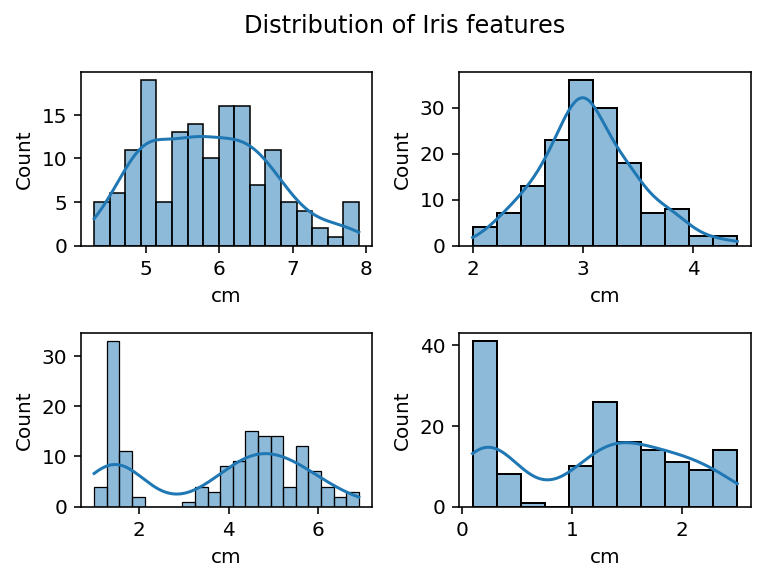

In [60]:
fig, axes = plt.subplots(2, 2)
fig.suptitle('Distribution of Iris features')
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for ax, data, name in zip(axes.flatten(), df.values.T, df.columns):
    sns.histplot(data, ax=ax, kde=True, bins=len(np.unique(data))//2)
    ax.set(xlabel='cm')

### Effect of holidays on births

From [Python Data Science Handbook](https://www.oreilly.com/library/view/python-data-science/9781491912126/)

In [ ]:
fp = 'https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv'

def sigma_clipper(df, column, sigmas=5):
    """
    Eliminate outliers using sigma-clipping.
    
    For a normal distribution, 0.74 is the factor that turns
    the IQR into the standard deviation, sigma. Derivation:
    for standard normal, sigma is 1, q1 and q3 are -0.675 and
    0.675, so that IQR = 1.35. Hence, factor = sigma / IQR
    = 1 / 1.35 = 0.74.
    """
    pcts = np.percentile(df.births, [25, 50, 75])
    mu, sigma = pcts[1], 0.74 * (pcts[2] - pcts[0])
    bound = sigmas * sigma
    return df.query(f'({column} > @mu - @bound) & ({column} < @mu + @bound)')


df = (pd.read_csv(fp)
      .dropna()
      .pipe(sigma_clipper, 'births'))
df.head(2)

In [67]:
# Prepare data

# Eliminate outliers using sigma-clipping
pcts = np.percentile(df.births, [25, 50, 75])
mu, sigma = pcts[1], 0.74 * (pcts[2] - pcts[0])
df = df.query('(births > @mu - 5 * @sigma) & (births < @mu + 5 * @sigma)')

# Create datetime index
df.index = pd.to_datetime(df.year * 10_000 + df.month * 100 + df.day, format='%Y%m%d')

# Make pivot table with month-day index and mean of births column
day_means = df.pivot_table('births', [df.index.month, df.index.day])

# Turn pivot index into year-month-day index (for leap year) for plotting
from datetime import date
day_means.index = [date(2020, month, day) for month, day in day_means.index]

In [66]:
df

year  month   day gender  births
1969-01-01  1969      1   1.0      F    4046
1969-01-01  1969      1   1.0      M    4440
1969-01-02  1969      1   2.0      F    4454
1969-01-02  1969      1   2.0      M    4548
1969-01-03  1969      1   3.0      F    4548
...          ...    ...   ...    ...     ...
1988-12-29  1988     12  29.0      M    5944
1988-12-30  1988     12  30.0      F    5742
1988-12-30  1988     12  30.0      M    6095
1988-12-31  1988     12  31.0      F    4435
1988-12-31  1988     12  31.0      M    4698

[14610 rows x 5 columns]

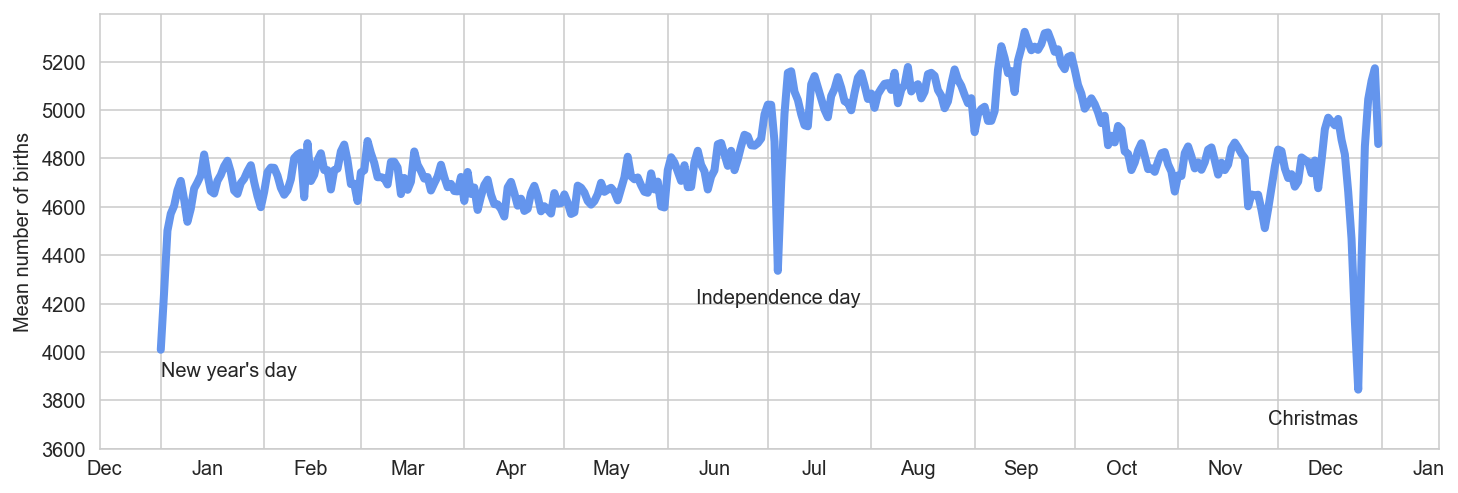

In [10]:
# Plot

fig, ax = plt.subplots(figsize=(12, 4))

style = dict(color='cornflowerblue', linewidth=4, style='-')
day_means.plot(ax=ax, legend=None, **style)

# Format
ax.set(ylim=(3600, None), ylabel='Mean number of births')
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'))

# Add text
ax.text('2020-01-01', 3900, "New year's day", ha='left')
ax.text('2020-07-04', 4200, 'Independence day', ha='center')
ax.text('2020-12-25', 3700, 'Christmas', ha='right');

### Seatle cycling data

From JVDP's [blog](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/)

In [7]:
file = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
data = pd.read_csv(file, skiprows=1, names=['date', 'total', 'east', 'west'],
                   parse_dates=True, index_col='date')

In [35]:
data.describe()

total          east          west
count  67118.000000  67118.000000  67118.000000
mean     112.912527     51.559835     61.352692
std      144.160880     66.522811     89.768937
min        0.000000      0.000000      0.000000
25%       14.000000      6.000000      7.000000
50%       60.000000     28.000000     30.000000
75%      147.000000     69.000000     74.000000
max     1097.000000    698.000000    850.000000

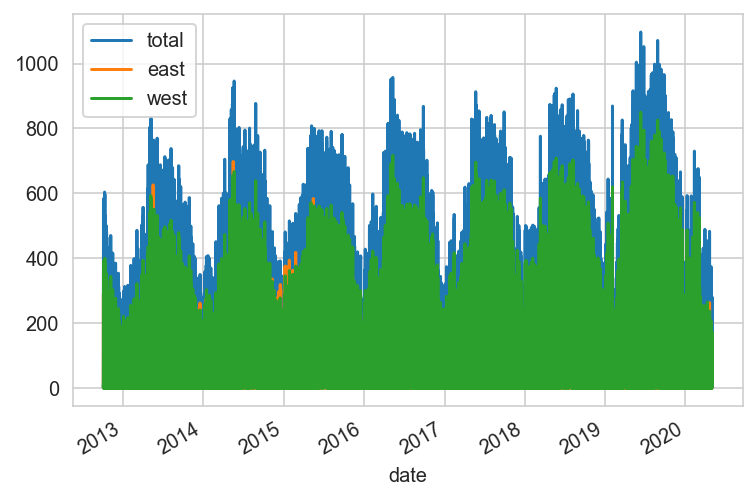

In [36]:
data.plot();

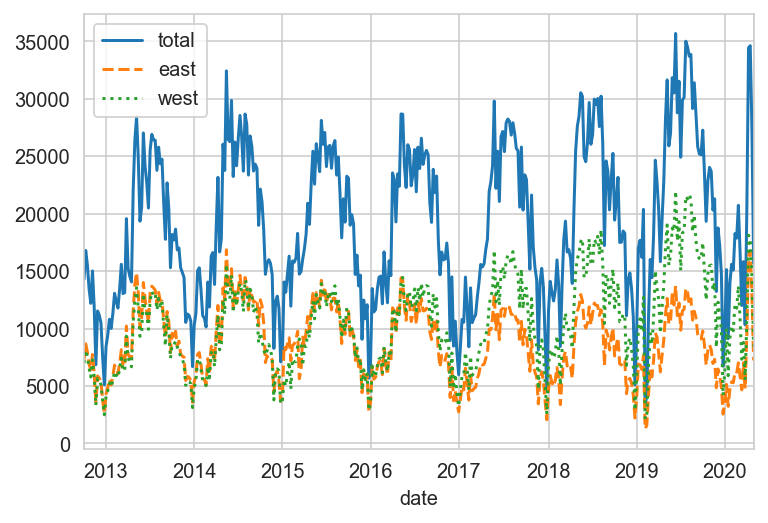

In [44]:
# Weekly aggregates

weekly = data.resample('W').sum()
weekly.plot(style=['-', '--', ':']);

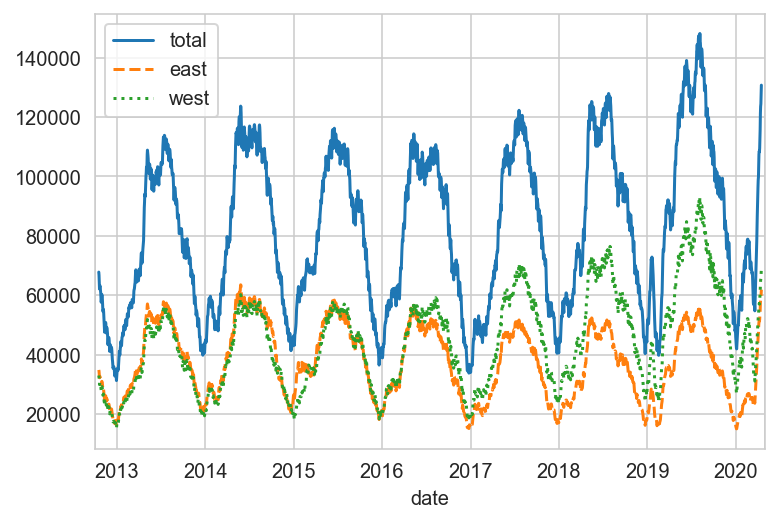

In [46]:
# Rolling window

daily = data.resample('D').sum()
daily.rolling(window=30, center=True).sum().plot(style=['-', '--', ':']);

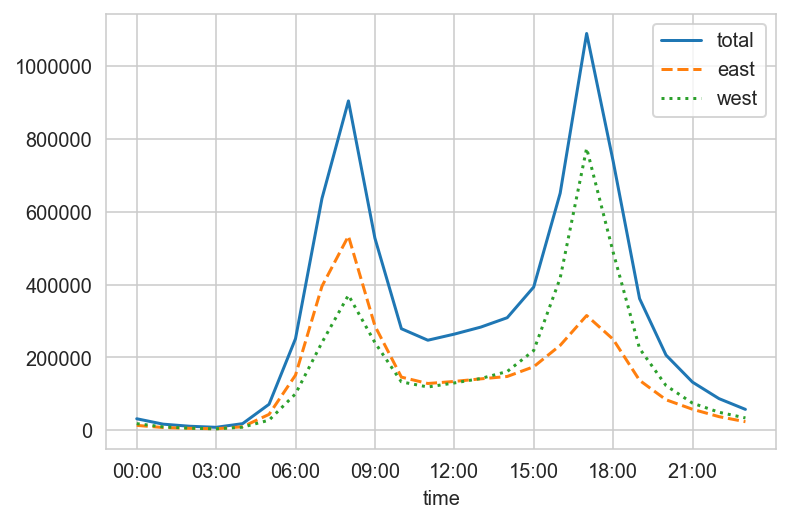

In [62]:
# By hour of day

by_time = data.groupby(data.index.time).sum()
hourly_ticks = 3 * 60 * 60 * np.arange(8)
by_time.plot(xticks=hourly_ticks, style=['-', '--', ':']);

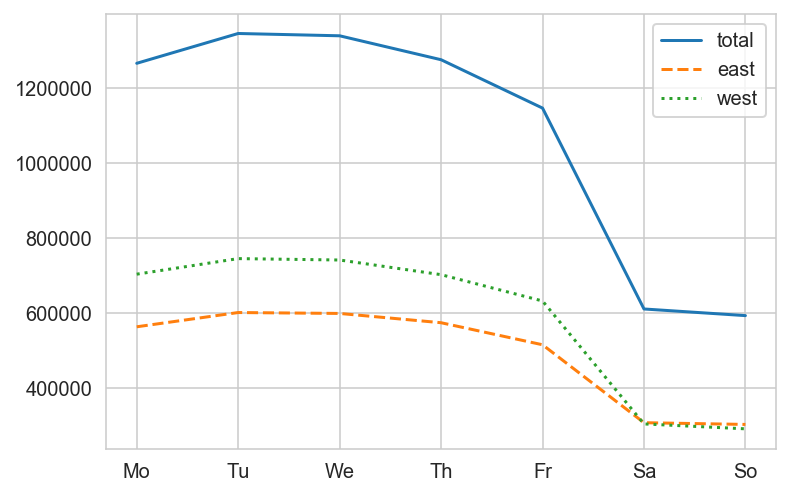

In [70]:
# By day of week

by_weekday = data.groupby(data.index.dayofweek).sum()
by_weekday.index = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'So']
by_weekday.plot(style=['-', '--', ':']);


In [95]:
mpl.get_configdir()

'/Users/fgu/.matplotlib'

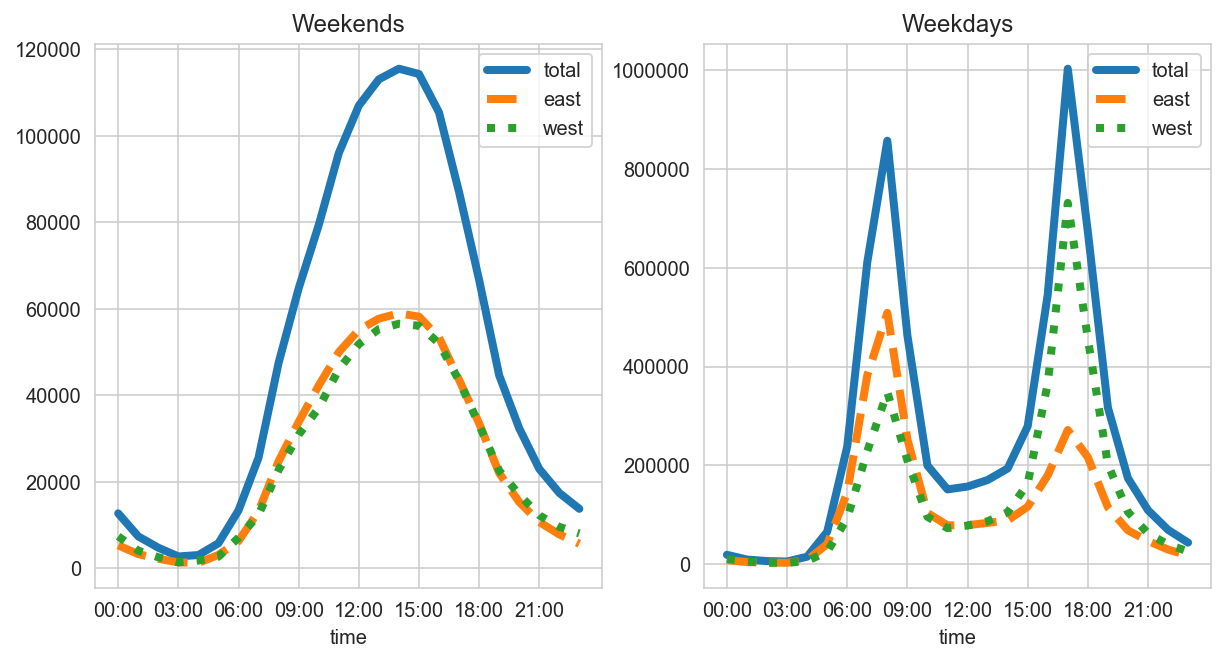

In [98]:
# Hourly by weekdays and weekends

wknd = np.where(data.index.dayofweek > 4, 'weekend', 'weekday')
hourly = data.groupby([wknd, data.index.time]).sum()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

hourly.loc['weekday'].plot(ax=ax1, title='Weekdays', xticks=hourly_ticks,
                           style=['-', '--', ':'])
hourly.loc['weekend'].plot(ax=ax0, title='Weekends', xticks=hourly_ticks,
                           style=['-', '--', ':']);

### USA.gov data from Bitly

From [Python for Data Analysis](https://www.oreilly.com/library/view/python-for-data/9781491957653/)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

%config InlineBackend.figure_format ='retina'

In [25]:
path = 'https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/datasets/bitly_usagov/example.txt'
df = pd.read_json(path, lines=True)
df.head()

a   c   nk  \
0  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...  US  1.0   
1                             GoogleMaps/RochesterNY  US  0.0   
2  Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...  US  1.0   
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...  BR  0.0   
4  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...  US  0.0   

                  tz  gr       g       h         l              al         hh  \
0   America/New_York  MA  A6qOVH  wfLQtf   orofrog  en-US,en;q=0.8  1.usa.gov   
1     America/Denver  UT  mwszkS  mwszkS     bitly             NaN       j.mp   
2   America/New_York  DC  xxr3Qb  xxr3Qb     bitly           en-US  1.usa.gov   
3  America/Sao_Paulo  27  zCaLwp  zUtuOu  alelex88           pt-br  1.usa.gov   
4   America/New_York  MA  9b6kNl  9b6kNl     bitly  en-US,en;q=0.8     bit.ly   

                                                   r  \
0  http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...   
1                           http://www.AwareMap.com/   
2                               http://t.co/03elZC4Q   
3                                             direct   
4                http://www.shrewsbury-ma.gov/selco/   

                                                   u             t  \
0        http://www.ncbi.nlm.nih.gov/pubmed/22415991  1.331923e+09   
1        http://www.monroecounty.gov/etc/911/rss.php  1.331923e+09   
2  http://boxer.senate.gov/en/press/releases/0316...  1.331923e+09   
3            http://apod.nasa.gov/apod/ap120312.html  1.331923e+09   
4  http://www.shrewsbury-ma.gov/egov/gallery/1341...  1.331923e+09   

             hc          cy                        ll  _heartbeat_   kw  
0  1.331823e+09     Danvers   [42.576698, -70.954903]          NaN  NaN  
1  1.308262e+09       Provo  [40.218102, -111.613297]          NaN  NaN  
2  1.331920e+09  Washington     [38.9007, -77.043098]          NaN  NaN  
3  1.331923e+09        Braz  [-23.549999, -46.616699]          NaN  NaN  
4  1.273672e+09  Shrewsbury   [42.286499, -71.714699]          NaN  NaN

Let's plot the most occuring time-zones.

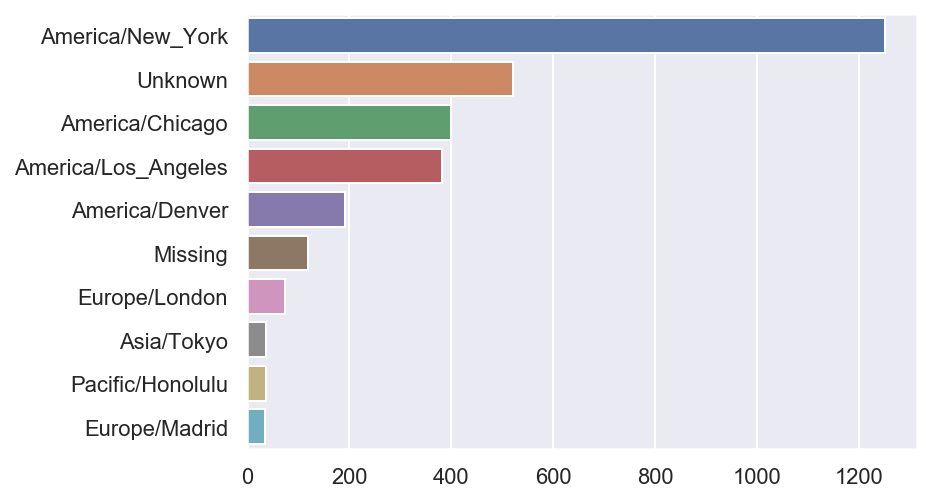

In [28]:
counts = df.tz.str.replace('^$', 'Unknown').fillna('Missing').value_counts()[:10]
sns.barplot(counts.values, counts.index);

Now, let's split the bars by operating system.

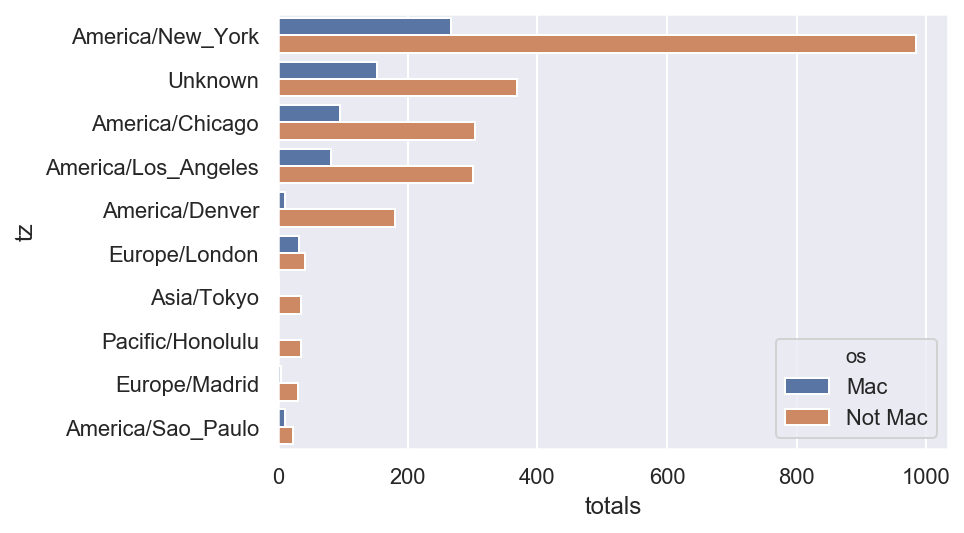

In [54]:
pd.Series.reverse = lambda self: self[::-1]  # Cool trick from here: https://stackoverflow.com/a/46624694

df['os'] = np.where(df.a.str.contains('Mac'), 'Mac', 'Not Mac')

agg_counts = (df.replace('^$', 'Unknown', regex=True)
              .groupby(['tz', 'os'])
              .size()
              .unstack()
              .fillna(0))

indexer = agg_counts.sum(1).argsort()
data = agg_counts.take(indexer[-10:]).reverse().stack()
data.name = 'totals'
data = data.reset_index()

sns.barplot(x='totals', y='tz', hue='os', data=data);

### MovieLens 1M dataset 

From [Python for Data Analysis](https://www.oreilly.com/library/view/python-for-data/9781491957653/)

In [2]:
!ls data/ml-1m

README      movies.dat  ratings.dat users.dat


In [3]:
import pandas as pd

In [4]:
path = 'data/ml-1m/'

unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table(path + 'users.dat', sep='::', engine='python', names=unames)

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table(path + 'ratings.dat', sep='::', engine='python', names=rnames)

mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table(path + 'movies.dat', sep='::', engine='python', names=mnames)

data = pd.merge(pd.merge(users, ratings), movies)
data.head()

user_id gender  age  occupation    zip  movie_id  rating  timestamp  \
0        1      F    1          10  48067      1193       5  978300760   
1        2      M   56          16  70072      1193       5  978298413   
2       12      M   25          12  32793      1193       4  978220179   
3       15      M   25           7  22903      1193       4  978199279   
4       17      M   50           1  95350      1193       5  978158471   

                                    title genres  
0  One Flew Over the Cuckoo's Nest (1975)  Drama  
1  One Flew Over the Cuckoo's Nest (1975)  Drama  
2  One Flew Over the Cuckoo's Nest (1975)  Drama  
3  One Flew Over the Cuckoo's Nest (1975)  Drama  
4  One Flew Over the Cuckoo's Nest (1975)  Drama

Calculate average ratings by gender

In [107]:
mean_ratings = data.pivot_table(values='rating', index='title',
                                columns='gender', aggfunc='mean')
mean_ratings.head()

gender                                F         M
title                                            
$1,000,000 Duck (1971)         3.375000  2.761905
'Night Mother (1986)           3.388889  3.352941
'Til There Was You (1997)      2.675676  2.733333
'burbs, The (1989)             2.793478  2.962085
...And Justice for All (1979)  3.828571  3.689024

Keep only movies with at least 200 ratings

In [108]:
ratings_count = data.groupby('title').size()
active_titles = ratings_count[ratings_count > 200].index

mean_ratings = mean_ratings.loc[active_titles]
# mean_ratings = mean_ratings.reindex(active_titles)  # alternative

Above was mainly to practice, what I actually want is to exclude movies with fewer than 200 ratings from the very start

In [109]:
rating_count = data.groupby('title').size()
active_movies = rating_count[rating_count > 200].index
data = data[data.title.isin(active_movies)]
data.head()

user_id gender  age  occupation    zip  movie_id  rating  timestamp  \
0        1      F    1          10  48067      1193       5  978300760   
1        2      M   56          16  70072      1193       5  978298413   
2       12      M   25          12  32793      1193       4  978220179   
3       15      M   25           7  22903      1193       4  978199279   
4       17      M   50           1  95350      1193       5  978158471   

                                    title genres  
0  One Flew Over the Cuckoo's Nest (1975)  Drama  
1  One Flew Over the Cuckoo's Nest (1975)  Drama  
2  One Flew Over the Cuckoo's Nest (1975)  Drama  
3  One Flew Over the Cuckoo's Nest (1975)  Drama  
4  One Flew Over the Cuckoo's Nest (1975)  Drama

Calculate ratings difference by gender (again, just for fun, and to compare to above result)

In [114]:
mean_ratings2 = data.pivot_table('rating', 'title', 'gender', 'mean')
all(mean_ratings2 == mean_ratings)

True

Look at top movis by gender

In [126]:
mean_ratings.sort_values('F', ascending=False).head()

gender                                                     F         M
title                                                                 
Close Shave, A (1995)                               4.644444  4.473795
Wrong Trousers, The (1993)                          4.588235  4.478261
General, The (1927)                                 4.575758  4.329480
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)       4.572650  4.464589
Wallace & Gromit: The Best of Aardman Animation...  4.563107  4.385075

In [127]:
mean_ratings.sort_values('M', ascending=False).head()

gender                                                     F         M
title                                                                 
Godfather, The (1972)                               4.314700  4.583333
Seven Samurai (The Magnificent Seven) (Shichini...  4.481132  4.576628
Shawshank Redemption, The (1994)                    4.539075  4.560625
Raiders of the Lost Ark (1981)                      4.332168  4.520597
Usual Suspects, The (1995)                          4.513317  4.518248

Calculate rating differences

In [131]:
mean_ratings['diff'] = np.abs(mean_ratings['F'] - mean_ratings['M'])
mean_ratings.sort_values('diff', ascending=False).head()

gender                                                     F         M  \
title                                                                    
Dirty Dancing (1987)                                3.790378  2.959596   
Good, The Bad and The Ugly, The (1966)              3.494949  4.221300   
To Wong Foo, Thanks for Everything! Julie Newma...  3.486842  2.795276   
Kentucky Fried Movie, The (1977)                    2.878788  3.555147   
Jumpin' Jack Flash (1986)                           3.254717  2.578358   

gender                                                  diff  
title                                                         
Dirty Dancing (1987)                                0.830782  
Good, The Bad and The Ugly, The (1966)              0.726351  
To Wong Foo, Thanks for Everything! Julie Newma...  0.691567  
Kentucky Fried Movie, The (1977)                    0.676359  
Jumpin' Jack Flash (1986)                           0.676359

Find movies with the most rating disagreement among all viwers

In [137]:
data.groupby('title').rating.std().sort_values(ascending=False).head()

title
Plan 9 from Outer Space (1958)         1.455998
Texas Chainsaw Massacre, The (1974)    1.332448
Dumb & Dumber (1994)                   1.321333
Blair Witch Project, The (1999)        1.316368
Natural Born Killers (1994)            1.307198
Name: rating, dtype: float64

### Baby names

From [Python for Data Analysis](https://www.oreilly.com/library/view/python-for-data/9781491957653/)

In [546]:
!head data/names/yob1880.txt

Mary,F,7065
Anna,F,2604
Emma,F,2003
Elizabeth,F,1939
Minnie,F,1746
Margaret,F,1578
Ida,F,1472
Alice,F,1414
Bertha,F,1320
Sarah,F,1288


In [547]:
import re

files = !ls data/names/yob*

pieces = []
columns = ['name', 'sex', 'births']

for file in files:
    frame = pd.read_csv(file, names=columns)
    
    year = int(re.findall('\d+', file)[0])
    frame['year'] = year
    pieces.append(frame)

names = pd.concat(pieces, ignore_index=True)
names.head()

name sex  births  year
0       Mary   F    7065  1880
1       Anna   F    2604  1880
2       Emma   F    2003  1880
3  Elizabeth   F    1939  1880
4     Minnie   F    1746  1880

In [548]:
years = range(1880, 2019)

pieces = []
columns = ['name', 'gender', 'births']

for year in years:
    path = 'data/names/yob%d.txt' % year
    frame = pd.read_csv(path, names=columns)

    frame['year'] = year
    pieces.append(frame)

names = pd.concat(pieces, ignore_index=True)
names.head()

name gender  births  year
0       Mary      F    7065  1880
1       Anna      F    2604  1880
2       Emma      F    2003  1880
3  Elizabeth      F    1939  1880
4     Minnie      F    1746  1880

Plot number of girls and boys born over time

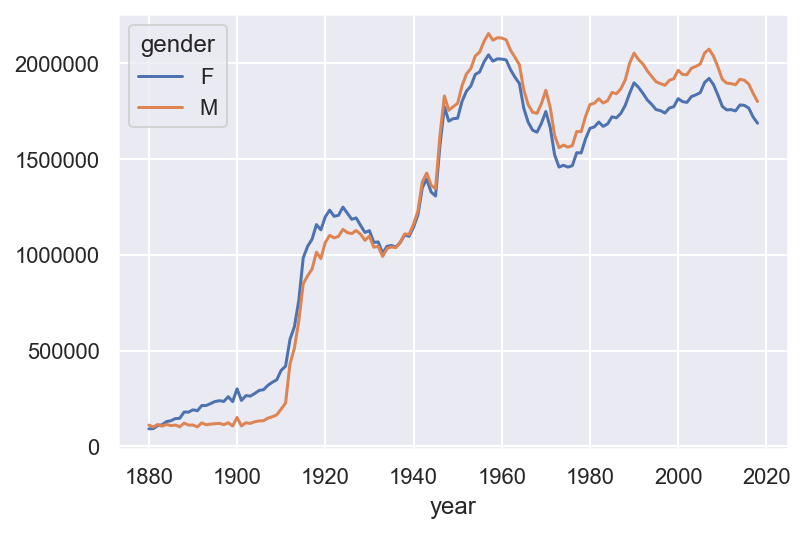

In [549]:
names.pivot_table('births', 'year', 'gender', 'sum').plot();

Add a proportion column

In [550]:
def add_prop(group):
    group['prop'] = group.births / group.births.sum()
    return group

names = names.groupby(['gender', 'year']).apply(add_prop)
names.head()

name gender  births  year      prop
0       Mary      F    7065  1880  0.077642
1       Anna      F    2604  1880  0.028617
2       Emma      F    2003  1880  0.022012
3  Elizabeth      F    1939  1880  0.021309
4     Minnie      F    1746  1880  0.019188

Check that prop sums to 1 for each year-gender group

In [551]:
names.groupby(['gender', 'year']).prop.sum()

gender  year
F       1880    1.0
        1881    1.0
        1882    1.0
        1883    1.0
        1884    1.0
               ... 
M       2014    1.0
        2015    1.0
        2016    1.0
        2017    1.0
        2018    1.0
Name: prop, Length: 278, dtype: float64

Keep only top 1000 names per gender and year

In [552]:
def top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]

top1000 = names.groupby(['gender', 'year']).apply(top1000).reset_index(drop=True)

Let's look at the number of births per year for common names

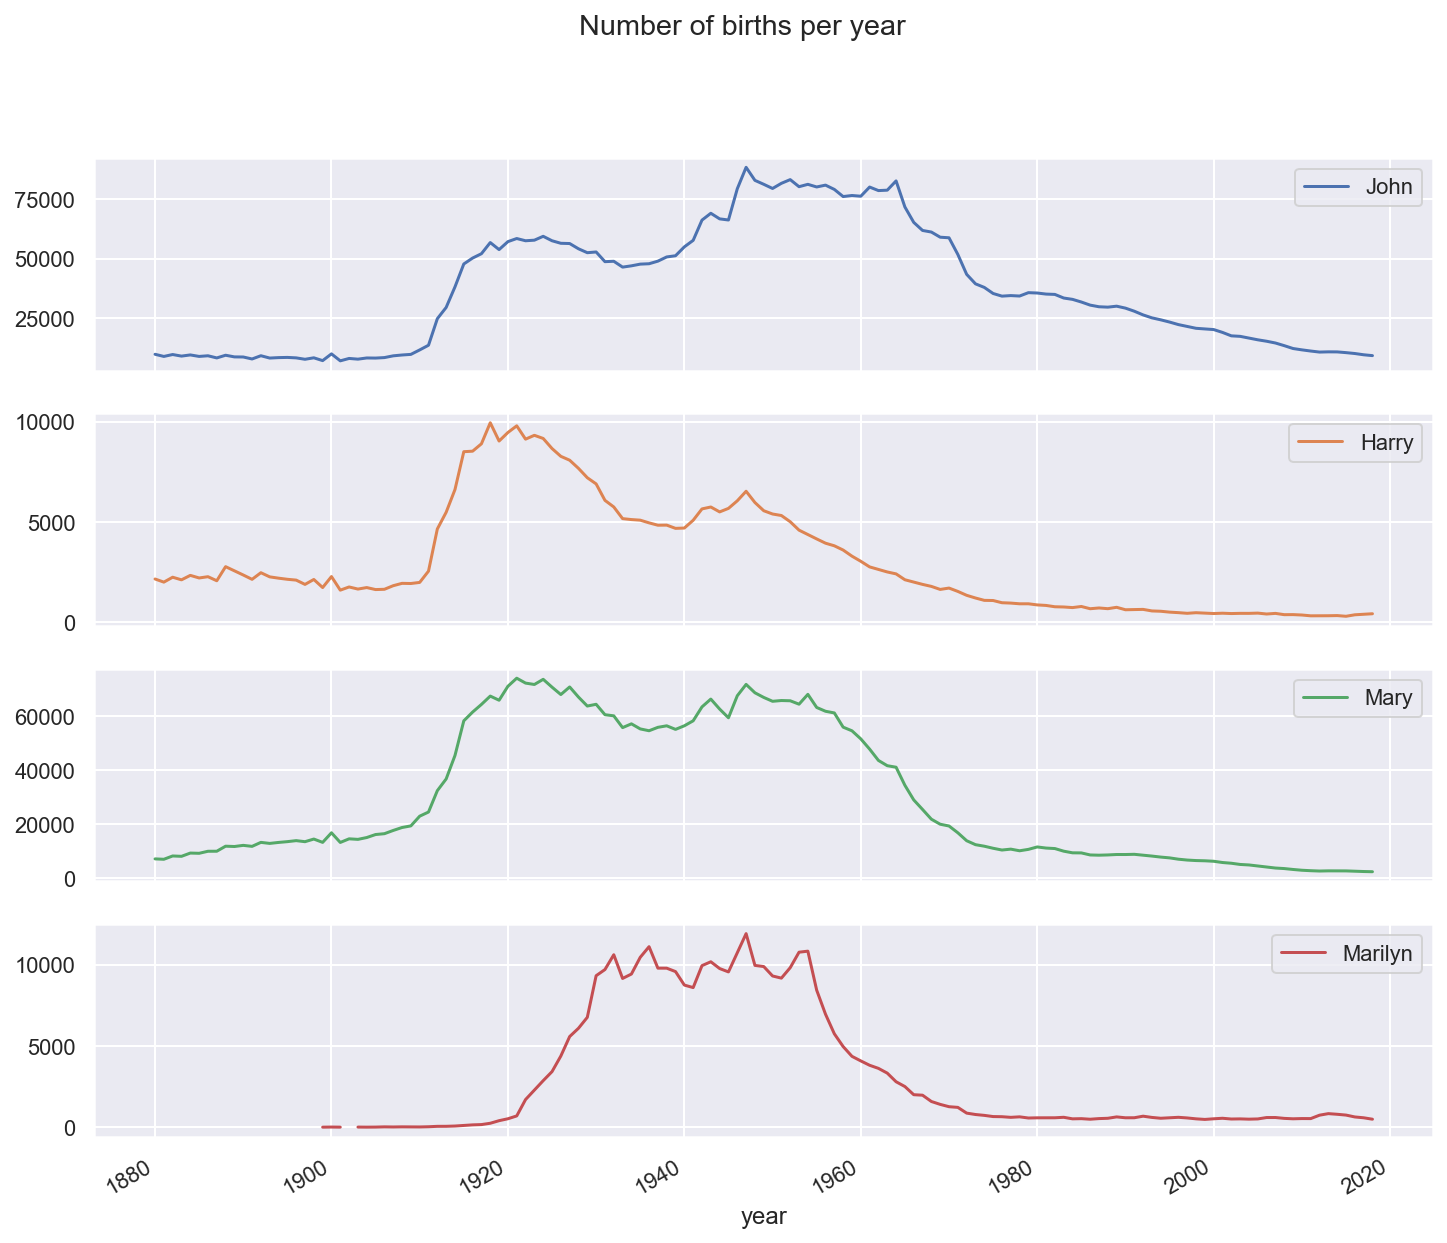

In [8]:
subset = ['John', 'Harry', 'Mary', 'Marilyn']

(names.pivot_table('births', 'year', 'name', 'sum')[subset]
 .plot(subplots=True, figsize=(12,10), title='Number of births per year'));

Plot suggest that common names have become less popular. This could be either because people use other names instead, or becasue people just use more names overall. Let's look into this. First by looking at the proportion of birhts for the top 1000 names.

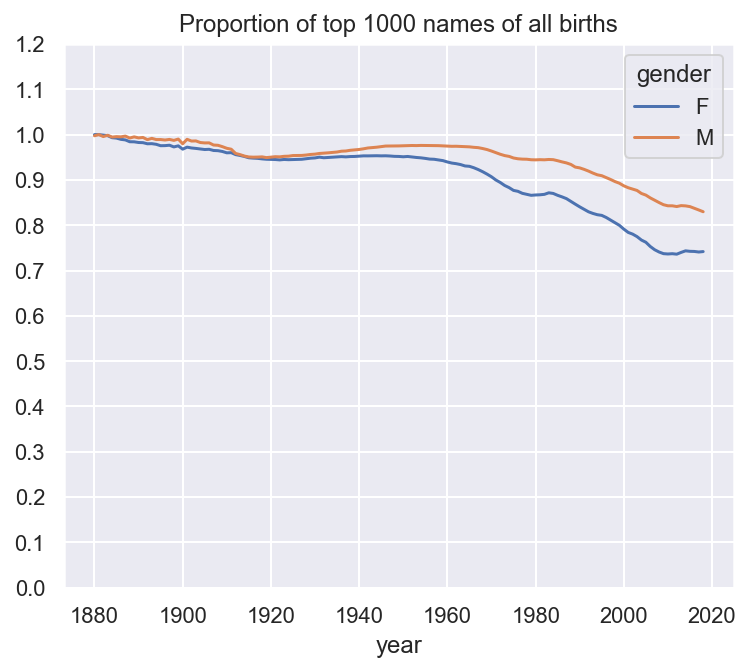

In [9]:
(top1000.pivot_table('prop', 'year', 'gender', 'sum')
 .plot(title='Proportion of top 1000 names of all births',
       figsize=(6, 5),
       yticks=np.linspace(0, 1.2, 13)));

It's clear from the above plot that the top 1000 names are becoming a smaller proportion of all names over time, indicating that naming diversity is increasing. To corroborate this, let's look at the number of names that account for 50 percent of all births in each year for each sex.

In [10]:
boys2018 = top1000[(top1000.year == 2018) & (top1000.gender == 'M')]
boys2018.sort_values('prop', ascending=False).prop.cumsum().searchsorted(.5) + 1

149

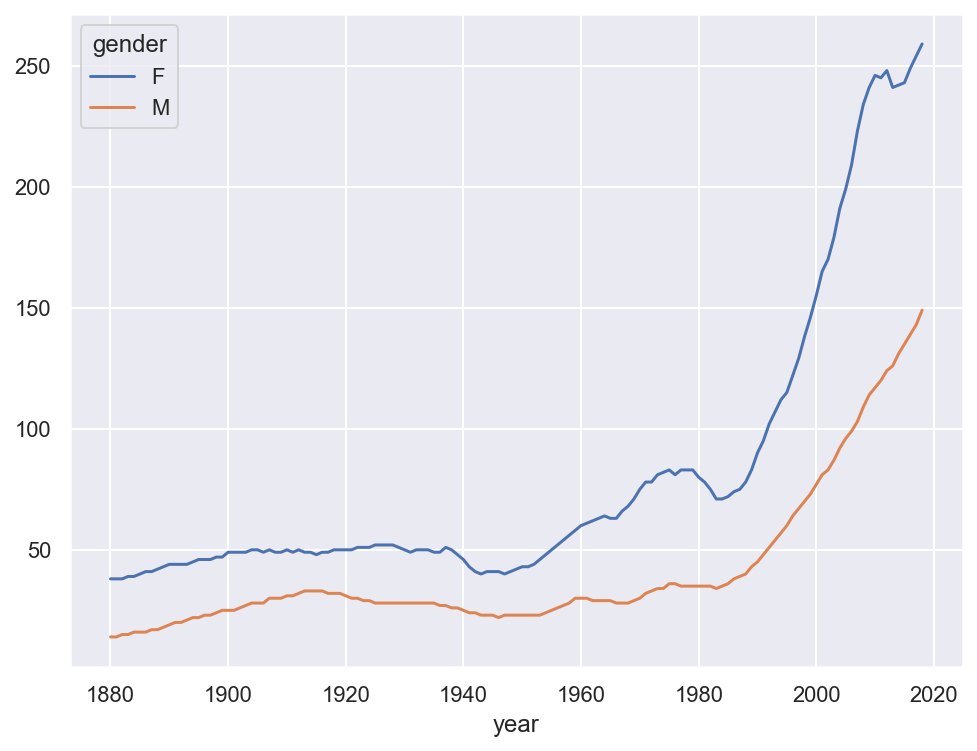

In [11]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values('prop', ascending=False)
    return group.prop.cumsum().searchsorted(.5) + 1

diversity = top1000.groupby(['gender', 'year']).apply(get_quantile_count).unstack(level=0)
diversity.plot(figsize=(8, 6));

Explore the last-letter revolution

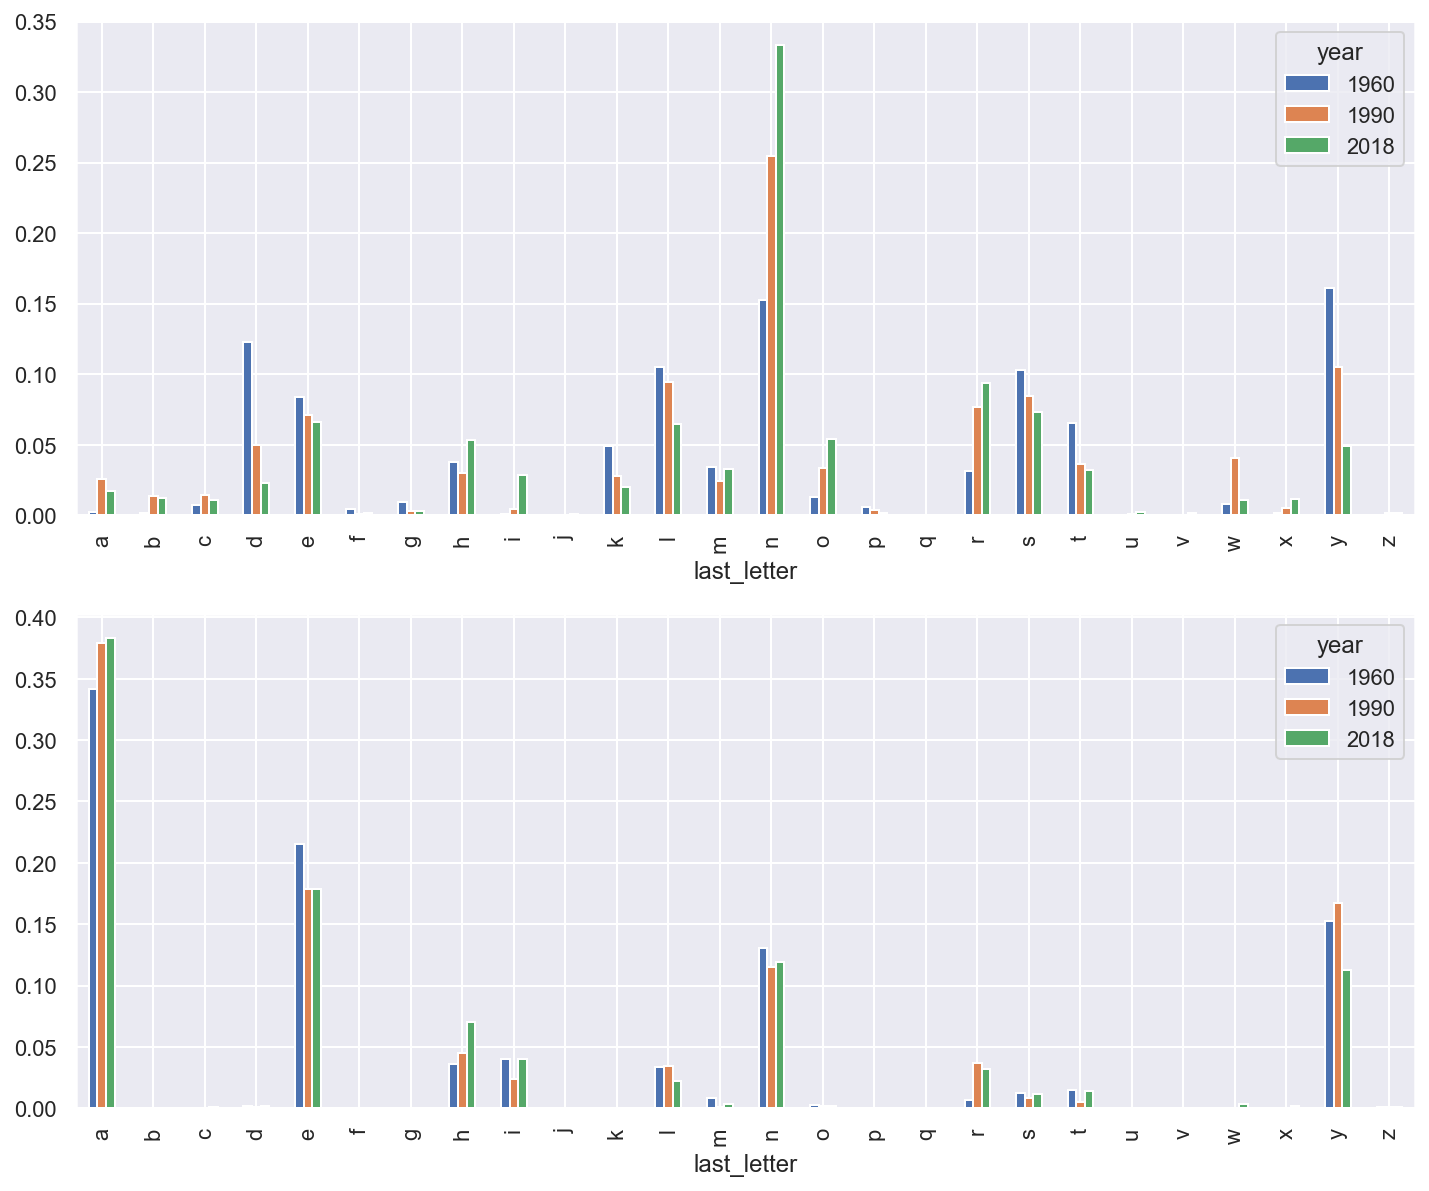

In [202]:
import matplotlib.pyplot as plt

def get_last_letter(name):
    return name[-1]

names['last_letter'] = names.name.map(get_last_letter)

table = names.pivot_table('births', 'last_letter', ['sex', 'year'], 'sum')

subtable = table.reindex(columns=[1960, 1990, 2018], level='year')
subtable = subtable / subtable.sum()
subtable

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10))

subtable['M'].plot(kind='bar', ax=ax1)
subtable['F'].plot(kind='bar', ax=ax2);

For boys names, d, n, and y have changed markedly in popularity over the past six decads. Let's look at this more closely.

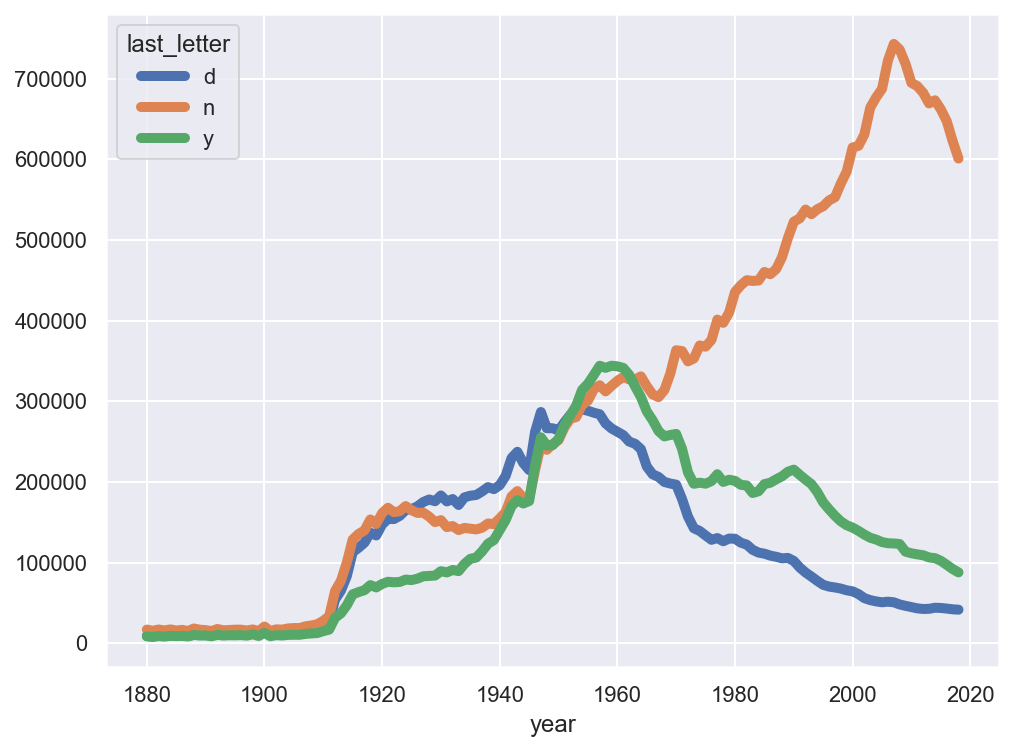

In [210]:
table['M'].reindex(['d', 'n', 'y']).T.plot(figsize=(8, 6), linewidth=5);

Leslie-like names have evolved from being boy to being girl names

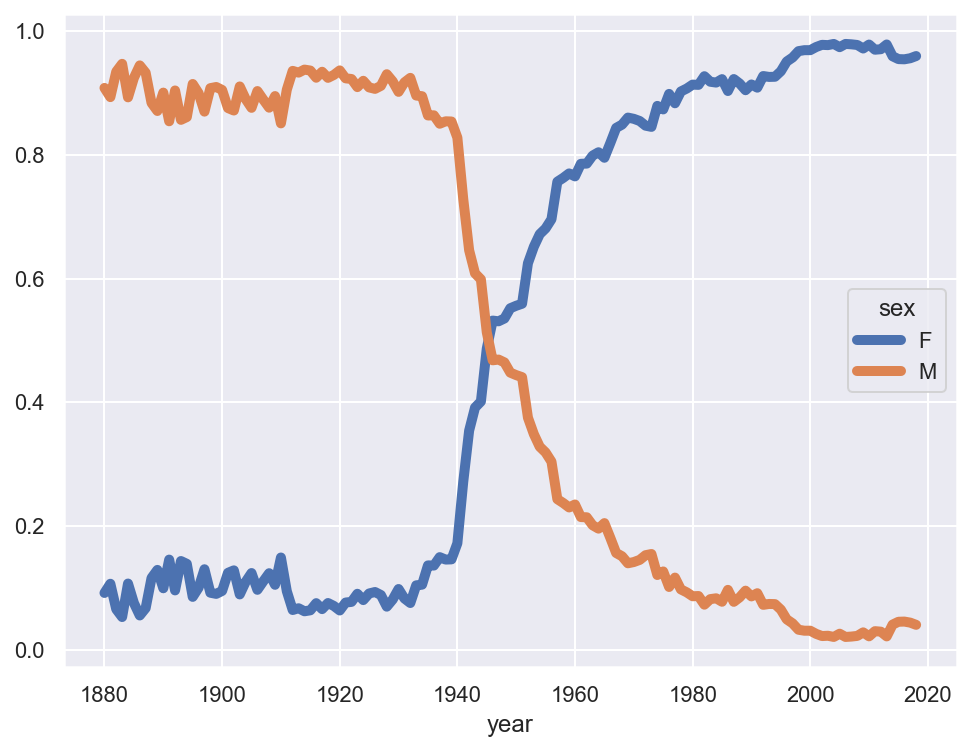

In [258]:
def normalise(df):
    return df.div(df.sum(1), axis='rows')

(names[names.name.str.lower().str.contains('^lesl')]
 .pivot_table('births', 'year', 'sex', 'sum')
 .pipe(normalise)
 .plot(figsize=(8, 6), linewidth=5));

Evolution of Molly and Fabian

In [274]:
names

name sex  births  year last_letter
0             Mary   F    7065  1880           y
1             Anna   F    2604  1880           a
2             Emma   F    2003  1880           a
3        Elizabeth   F    1939  1880           h
4           Minnie   F    1746  1880           e
...            ...  ..     ...   ...         ...
1957041      Zylas   M       5  2018           s
1957042      Zyran   M       5  2018           n
1957043      Zyrie   M       5  2018           e
1957044      Zyron   M       5  2018           n
1957045      Zzyzx   M       5  2018           x

[1957046 rows x 5 columns]

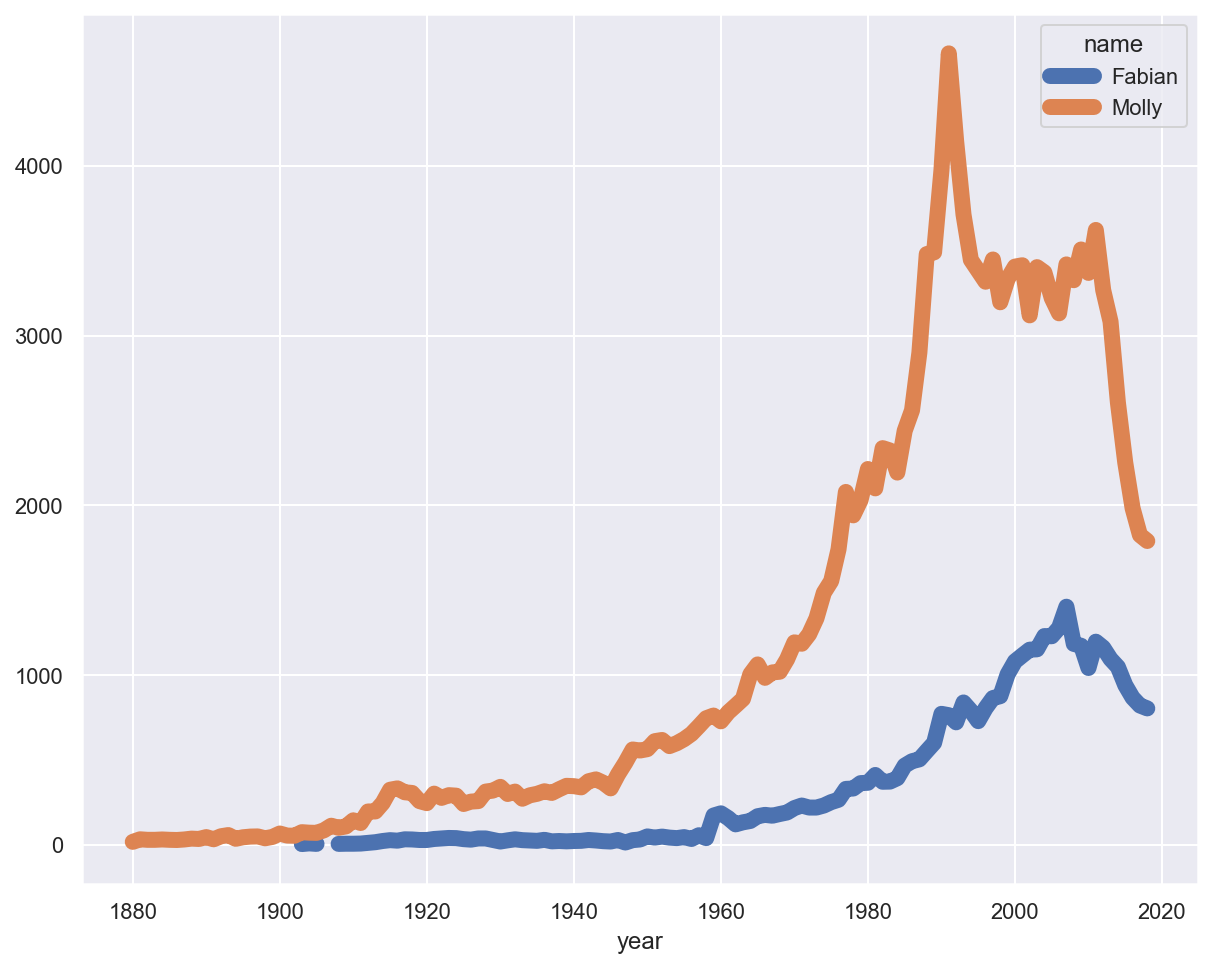

In [296]:
(names[names.name.isin(['Molly', 'Fabian'])]
 .pivot_table('births', 'year', 'name', 'sum')
 .plot(figsize=(10, 8), linewidth=8));

### Baby names in Switzerland

In [2]:
ls data/ch-names/

f.xlsx  m.xlsx


In [3]:
genders = ['f', 'm']

def rename_cols(df, names):
    df.columns = names
    return df

pieces = []
columns = ['name', 'year', 'births', 'rank']

for gender in genders:    
    path = 'data/ch-names/%s.xlsx' % gender
    data = (pd.read_excel(path, header=[2, 3], index_col=0, skipfooter=5)
         .stack(level=0)
         .reset_index()
         .pipe(rename_cols, columns)
         .assign(gender=gender))
    
    pieces.append(data)

names = pd.concat(pieces, ignore_index=True)
names

name  year  births  rank gender
0       Emma  1998      88    78      f
1       Emma  1999      80    85      f
2       Emma  2000     127    46      f
3       Emma  2001     116    46      f
4       Emma  2002     147    36      f
...      ...   ...     ...   ...    ...
41995  Rúben  2014       5  1071      m
41996  Rúben  2015       4  1263      m
41997  Rúben  2016       6   972      m
41998  Rúben  2017      15   515      m
41999  Rúben  2018       7   924      m

[42000 rows x 5 columns]

In [4]:
files = !ls data/ch-names/*

pieces = []
columns = ['name', 'year', 'births']

for file in files:    
    frame = (pd.read_excel(file, header=[2, 3], index_col=0, skipfooter=5)
             .stack(level=[0]).reset_index().drop('Rang', axis=1))

    frame.columns = columns
    gender = file[-6]
    frame['gender'] = gender 
    pieces.append(frame)
    
table = pd.concat(pieces, ignore_index=True) 
table.head()

name  year  births gender
0  Emma  1998      88      f
1  Emma  1999      80      f
2  Emma  2000     127      f
3  Emma  2001     116      f
4  Emma  2002     147      f

Add proportions and rank columns

In [4]:
def calc_prop(group):
    group['prop'] = group.births / group.births.sum() * 100
    return group

table = table.groupby(['year', 'gender']).apply(calc_prop)
table['rank'] = table.groupby(['year', 'gender']).births.rank(method='min')

Most popular names by year

In [20]:
def top_n(group, n=5):
    return group.sort_values('births', ascending=False)[:n]

num_names = 10
years = [1998]

(table.groupby(['year', 'gender'])
 .apply(top_n, num_names)
 .drop(['year', 'gender'], axis=1)
 .reset_index(level=2, drop=True)
 .loc[years])

name  births      prop    rank
year gender                                    
1998 m           Luca     648  2.214173  1000.0
     m          David     528  1.804141   999.0
     m          Simon     511  1.746053   998.0
     m          Marco     435  1.486366   997.0
     m           Joel     424  1.448780   996.0
     m        Michael     407  1.390692   995.0
     m          Lukas     392  1.339438   994.0
     m        Nicolas     375  1.281350   993.0
     m         Fabian     368  1.257432   992.0
     m          Kevin     350  1.195927   991.0
     w          Laura     607  2.405675  1000.0
     w         Celine     414  1.640774   999.0
     w          Sarah     407  1.613031   998.0
     w        Jessica     391  1.549620   997.0
     w            Lea     375  1.486208   996.0
     w       Michelle     357  1.414870   995.0
     w           Sara     344  1.363348   994.0
     w        Vanessa     320  1.268231   993.0
     w           Lara     308  1.220672   992.0
     w          Julia     299  1.185003   991.0

What's going on with girl names ending in 'a'?

In [805]:
table[table.name.str.endswith('a')]

0        False
1        False
2        False
3        False
4        False
         ...  
41995    False
41996    False
41997    False
41998    False
41999    False
Name: name, Length: 42000, dtype: bool

In [7]:
girl_names = ['Emma', 'Ivy', 'Audrey', 'Vivien']

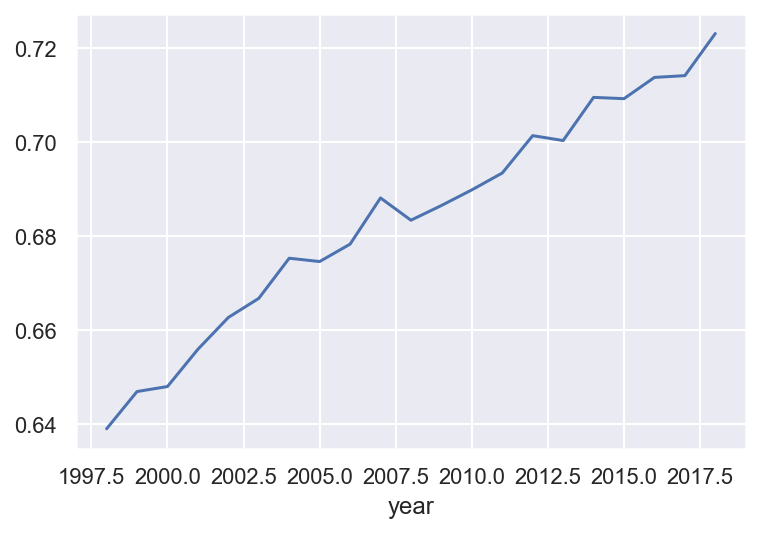

In [803]:
def get_last_letter(name):
    return name[-1]

table['last_letter'] = table.name.map(get_last_letter)

last_letters = table[table.gender == 'w'].pivot_table('births', 'last_letter', 'year', 'sum') 
last_letters = last_letters / last_letters.sum()
last_letters.T['a'].plot()

Popularity of names over time

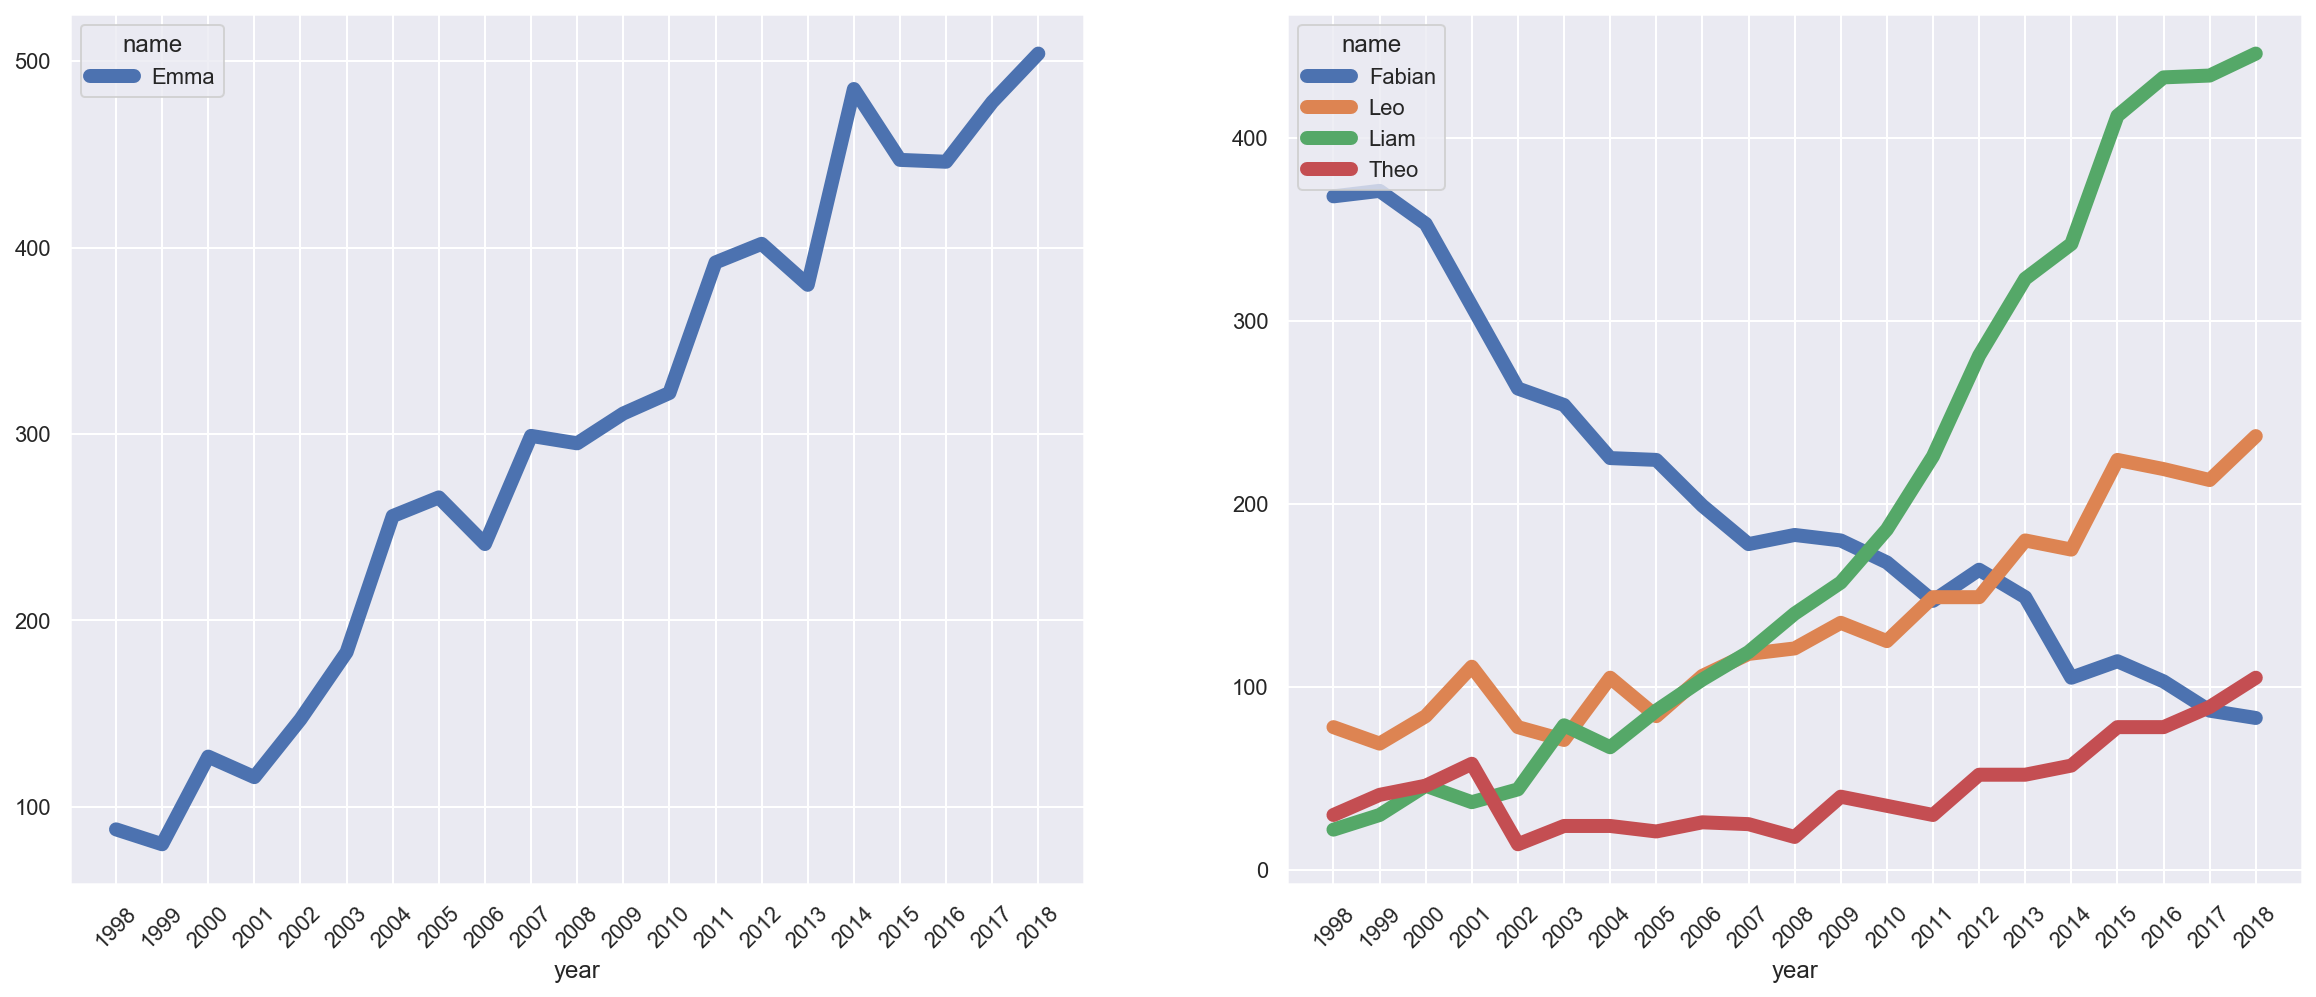

In [21]:
import matplotlib.pyplot as plt

def plot_births(names, axis, values='prop'):
    (table[(table.name.isin(names))]
     .pivot_table(values, 'year', 'name', 'sum')
     .plot(ax=axis, xticks=range(1998, 2019), rot=45, linewidth=7))

    
fig, (left, right) = plt.subplots(1, 2, figsize=(20, 8))

girl_names = ['Emma']
boy_names = ['Liam', 'Leo', 'Theo', 'Fabian']

plot_births(girl_names, left, values='births')
plot_births(boy_names, right, values='births')

### USDA Food database

From [Python for Data Analysis](https://www.oreilly.com/library/view/python-for-data/9781491957653/)

In [100]:
ls data/usda_foods.json

chap14-examples.ipynb  data/


In [105]:
import json

db = json.load(open('data/usda_foods.json'))
len(db)

In [110]:
db[0].keys()

dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])

In [112]:
pd.DataFrame(db[0]['nutrients'])

value units                         description        group
0     25.180     g                             Protein  Composition
1     29.200     g                   Total lipid (fat)  Composition
2      3.060     g         Carbohydrate, by difference  Composition
3      3.280     g                                 Ash        Other
4    376.000  kcal                              Energy       Energy
..       ...   ...                                 ...          ...
157    1.472     g                              Serine  Amino Acids
158   93.000    mg                         Cholesterol        Other
159   18.584     g        Fatty acids, total saturated        Other
160    8.275     g  Fatty acids, total monounsaturated        Other
161    0.830     g  Fatty acids, total polyunsaturated        Other

[162 rows x 4 columns]

Produce df with info variables

In [124]:
info_keys = ['description', 'id', 'manufacturer', 'group']
new_col_names = {'description': 'food', 'group': 'fgroup'}

info = pd.DataFrame(db, columns=info_keys)
info = info.rename(columns=new_col_names)
info.head()

food    id manufacturer  \
0                     Cheese, caraway  1008                
1                     Cheese, cheddar  1009                
2                        Cheese, edam  1018                
3                        Cheese, feta  1019                
4  Cheese, mozzarella, part skim milk  1028                

                   fgroup  
0  Dairy and Egg Products  
1  Dairy and Egg Products  
2  Dairy and Egg Products  
3  Dairy and Egg Products  
4  Dairy and Egg Products

Create a df with all the nutrient info for each food

In [125]:
new_col_names = {'description': 'nutrient', 'group': 'ngroup'}

pieces = []

for rec in db:
    nuts = pd.DataFrame(rec['nutrients'])
    nuts['id'] = rec['id']
    pieces.append(nuts)

nutrients = pd.concat(pieces, ignore_index=True)
nutrients = nutrients.rename(columns=new_col_names)
nutrients.head()

value units                     nutrient       ngroup    id
0   25.18     g                      Protein  Composition  1008
1   29.20     g            Total lipid (fat)  Composition  1008
2    3.06     g  Carbohydrate, by difference  Composition  1008
3    3.28     g                          Ash        Other  1008
4  376.00  kcal                       Energy       Energy  1008

Combine info and nutrient dfs

In [128]:
foods = pd.merge(info, nutrients).drop_duplicates()
foods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 389354
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   food          375176 non-null  object 
 1   id            375176 non-null  int64  
 2   manufacturer  293054 non-null  object 
 3   fgroup        375176 non-null  object 
 4   value         375176 non-null  float64
 5   units         375176 non-null  object 
 6   nutrient      375176 non-null  object 
 7   ngroup        375176 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 25.8+ MB


Plot nutrient content by food group

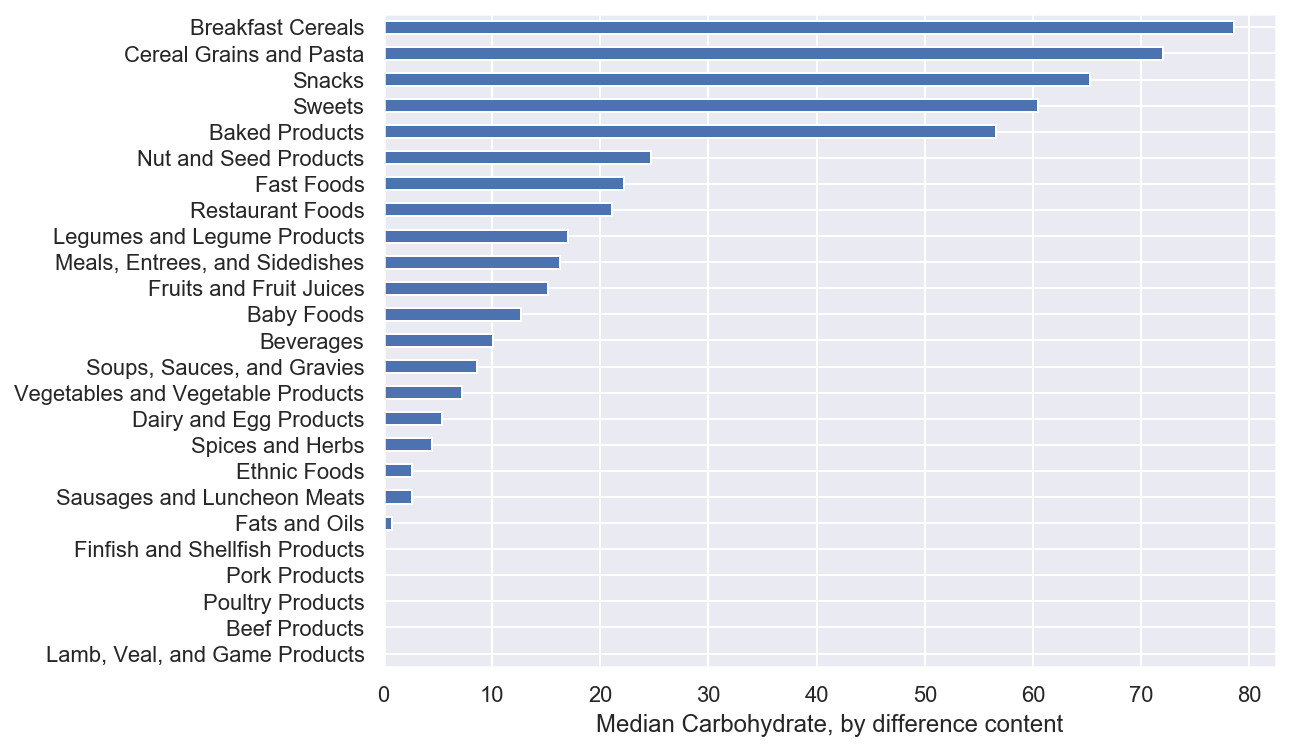

In [170]:
nutrient = 'Carbohydrate, by difference'

(foods[foods.nutrient.isin([nutrient])]
 .groupby('fgroup')
 .value
 .quantile(.5)
 .sort_values()
 .plot(kind='barh', figsize=(8, 6))
 .set(xlabel='Median %s content' % nutrient, ylabel=''));

Find the food with the maxium nutritional content for each nutrient

In [181]:
get_max = lambda x: x.loc[x.value.idxmax()]
foods.groupby('nutrient').apply(get_max).head()

food     id  \
nutrient                                                                     
Adjusted Protein             Baking chocolate, unsweetened, squares  19078   
Alanine                           Gelatins, dry powder, unsweetened  19177   
Alcohol, ethyl    Alcoholic beverage, distilled, all (gin, rum, ...  14533   
Arginine                               Seeds, sesame flour, low-fat  12033   
Ash                          Desserts, rennin, tablets, unsweetened  19225   

                 manufacturer                 fgroup   value units  \
nutrient                                                             
Adjusted Protein                              Sweets  12.900     g   
Alanine                                       Sweets   8.009     g   
Alcohol, ethyl                             Beverages  42.500     g   
Arginine                       Nut and Seed Products   7.436     g   
Ash                                           Sweets  72.500     g   

                          nutrient       ngroup  
nutrient                                         
Adjusted Protein  Adjusted Protein  Composition  
Alanine                    Alanine  Amino Acids  
Alcohol, ethyl      Alcohol, ethyl        Other  
Arginine                  Arginine  Amino Acids  
Ash                            Ash        Other

### FEC 2012 presidential election campaign contributions

From [Python for Data Analysis](https://www.oreilly.com/library/view/python-for-data/9781491957653/)

In [261]:
columns = {'cand_nm':'candidate',
           'contbr_city':'city', 
           'contbr_occupation':'occupation', 
           'contb_receipt_amt':'amount', 
           'contb_receipt_dt':'date'}

parties = {'Bachmann, Michelle': 'r', 
           'Romney, Mitt': 'r', 
           'Obama, Barack': 'd',
           "Roemer, Charles E. 'Buddy' III": 'r', 
           'Pawlenty, Timothy': 'r',
           'Johnson, Gary Earl': 'r', 
           'Paul, Ron': 'r', 
           'Santorum, Rick': 'r',
           'Cain, Herman': 'r',
           'Gingrich, Newt': 'r',
           'McCotter, Thaddeus G': 'r',
           'Huntsman, Jon': 'r', 
           'Perry, Rick': 'r'}

path = 'https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/datasets/fec/P00000001-ALL.csv'

fec = (pd.read_csv(path)
       [columns.keys()]
       .rename(columns=columns)
       .assign(party = lambda df: df.candidate.map(parties))) 

/Users/fgu/miniconda3/envs/basics/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [262]:
fec.head()

candidate                city             occupation  amount  \
0  Bachmann, Michelle              MOBILE                RETIRED   250.0   
1  Bachmann, Michelle              MOBILE                RETIRED    50.0   
2  Bachmann, Michelle              LANETT  INFORMATION REQUESTED   250.0   
3  Bachmann, Michelle             PIGGOTT                RETIRED   250.0   
4  Bachmann, Michelle  HOT SPRINGS NATION                RETIRED   300.0   

        date party  
0  20-JUN-11     r  
1  23-JUN-11     r  
2  05-JUL-11     r  
3  01-AUG-11     r  
4  20-JUN-11     r

Compare total donations

In [258]:
fec.groupby('party').amount.sum()

party
d    1.335026e+08
r    1.652488e+08
Name: amount, dtype: float64

Compare donations by occupation

In [268]:
# Finishing this would take some extra work...
occ_mapping = {'INFORMATION REQUESTED':'Not provided',
               'INFORMATION REQUESTED PER BEST EFFORTS': 'Not provided'}

f = lambda x: occ_mapping.get(x, x)

fec.occupation = fec.occupation.map(f)
fec

candidate                city                    occupation  \
0        Bachmann, Michelle              MOBILE                       RETIRED   
1        Bachmann, Michelle              MOBILE                       RETIRED   
2        Bachmann, Michelle              LANETT                  Not provided   
3        Bachmann, Michelle             PIGGOTT                       RETIRED   
4        Bachmann, Michelle  HOT SPRINGS NATION                       RETIRED   
...                     ...                 ...                           ...   
1001726         Perry, Rick      INFO REQUESTED                  Not provided   
1001727         Perry, Rick      INFO REQUESTED                BUSINESS OWNER   
1001728         Perry, Rick      INFO REQUESTED                  Not provided   
1001729         Perry, Rick      INFO REQUESTED  LONGWALL MAINTENANCE FOREMAN   
1001730         Perry, Rick      INFO REQUESTED                  Not provided   

         amount       date party  
0         250.0  20-JUN-11     r  
1          50.0  23-JUN-11     r  
2         250.0  05-JUL-11     r  
3         250.0  01-AUG-11     r  
4         300.0  20-JUN-11     r  
...         ...        ...   ...  
1001726  5000.0  29-SEP-11     r  
1001727  2500.0  30-SEP-11     r  
1001728   500.0  29-SEP-11     r  
1001729   500.0  30-SEP-11     r  
1001730  2500.0  31-AUG-11     r  

[1001731 rows x 6 columns]

Discretise donations into buckets for contribution size

## Seaborn

From [Python Data Science Handbook](https://www.oreilly.com/library/view/python-data-science/9781491912126/)

### Create a simple random walk plot using default

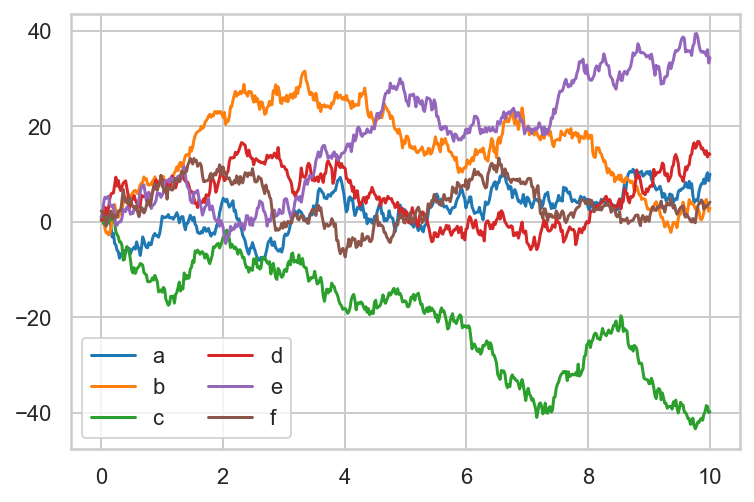

In [4]:
rng = np.random.RandomState(2312)
x = np.linspace(0, 10, 500)
y = np.cumsum(rng.randn(500, 6), axis=0)

plt.plot(x, y)
plt.legend('abcdef', ncol=2, loc='lower left');

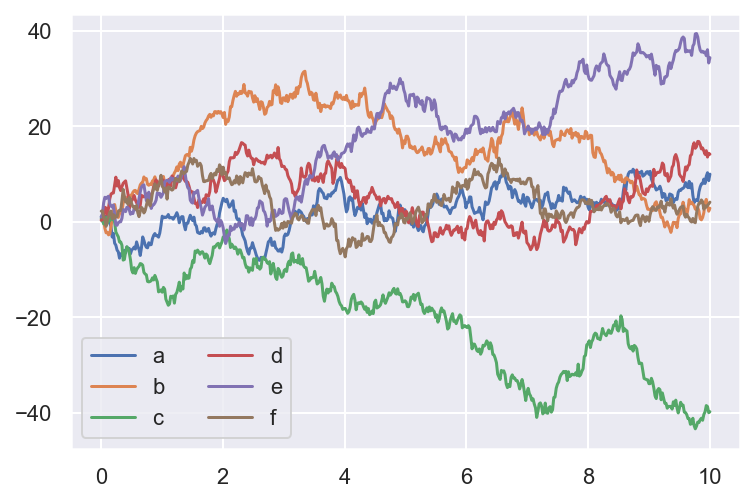

In [6]:
# Use seaborn style
import seaborn as sns
sns.set()
plt.plot(x, y);
plt.legend('abcdef', ncol=2, loc='lower left');

### Explore marathon data

In [136]:
from datetime import timedelta

# Read data
def convert_time(s):
    h, m, s = map(int, s.split(':'))
    return timedelta(hours=h, minutes=m, seconds=s)

file = 'https://raw.githubusercontent.com/jakevdp/marathon-data/master/marathon-data.csv'
df = pd.read_csv(file,
                 converters={'split': convert_time, 'final': convert_time})

# Add times in seconds
df['split_sec'] = df.split.astype(int) / 1E9
df['final_sec'] = df.final.astype(int) / 1E9

print(df.shape)
df.head()

(37250, 6)


age gender    split    final  split_sec  final_sec
0   33      M 01:05:38 02:08:51     3938.0     7731.0
1   32      M 01:06:26 02:09:28     3986.0     7768.0
2   31      M 01:06:49 02:10:42     4009.0     7842.0
3   38      M 01:06:16 02:13:45     3976.0     8025.0
4   31      M 01:06:32 02:13:59     3992.0     8039.0

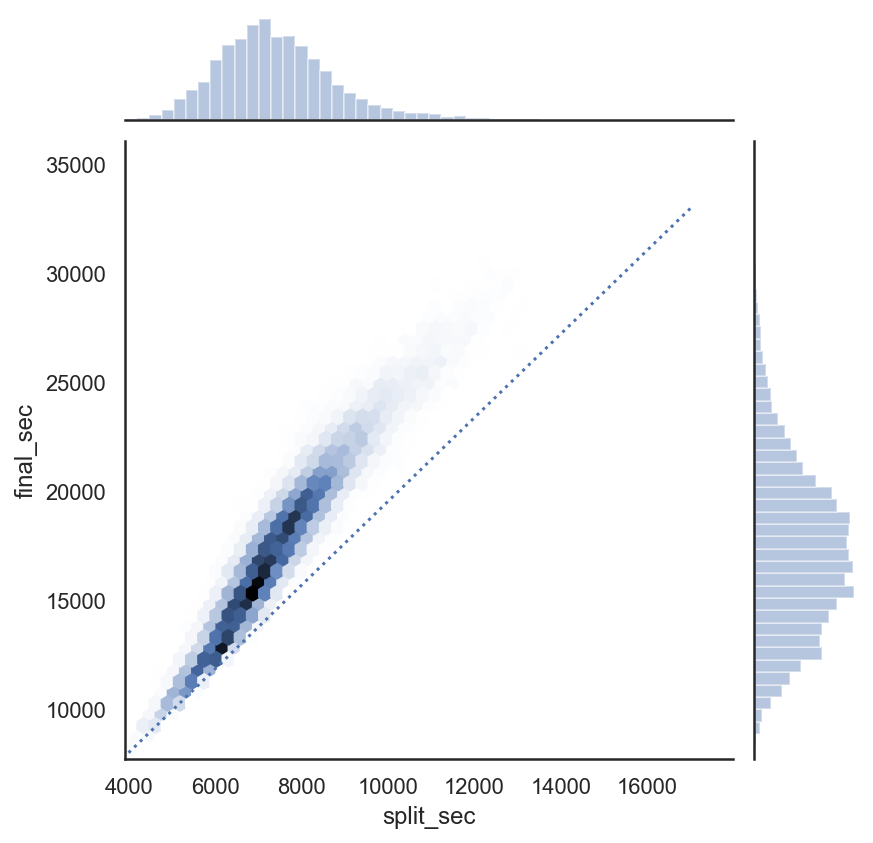

In [142]:
# Jointplot to get first impression of data

with sns.axes_style('white'):
    g = sns.jointplot('split_sec', 'final_sec', data=df, kind='hex')
    g.ax_joint.plot(np.linspace(4000, 17000), np.linspace(8000, 33000), ':')

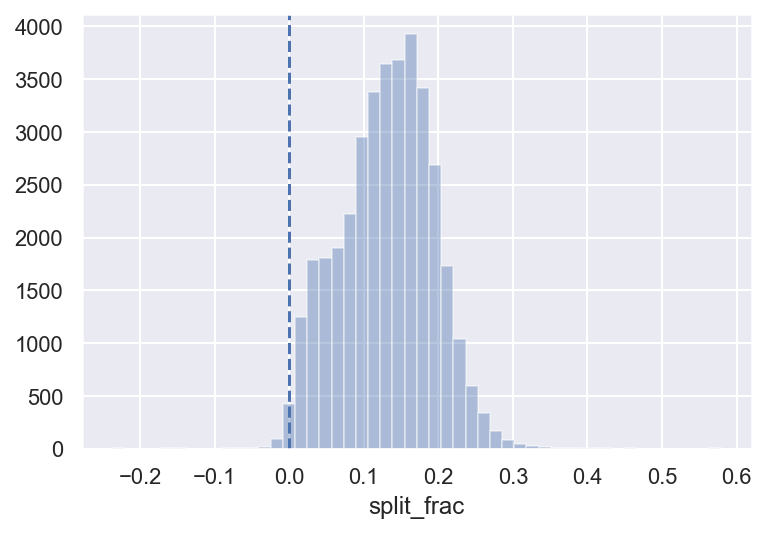

In [148]:
# Histogram of split fraction

df['split_frac'] = 1 - 2 * df.split_sec / df.final_sec
sns.distplot(df.split_frac, kde=False)
plt.axvline(0, linestyle='--');

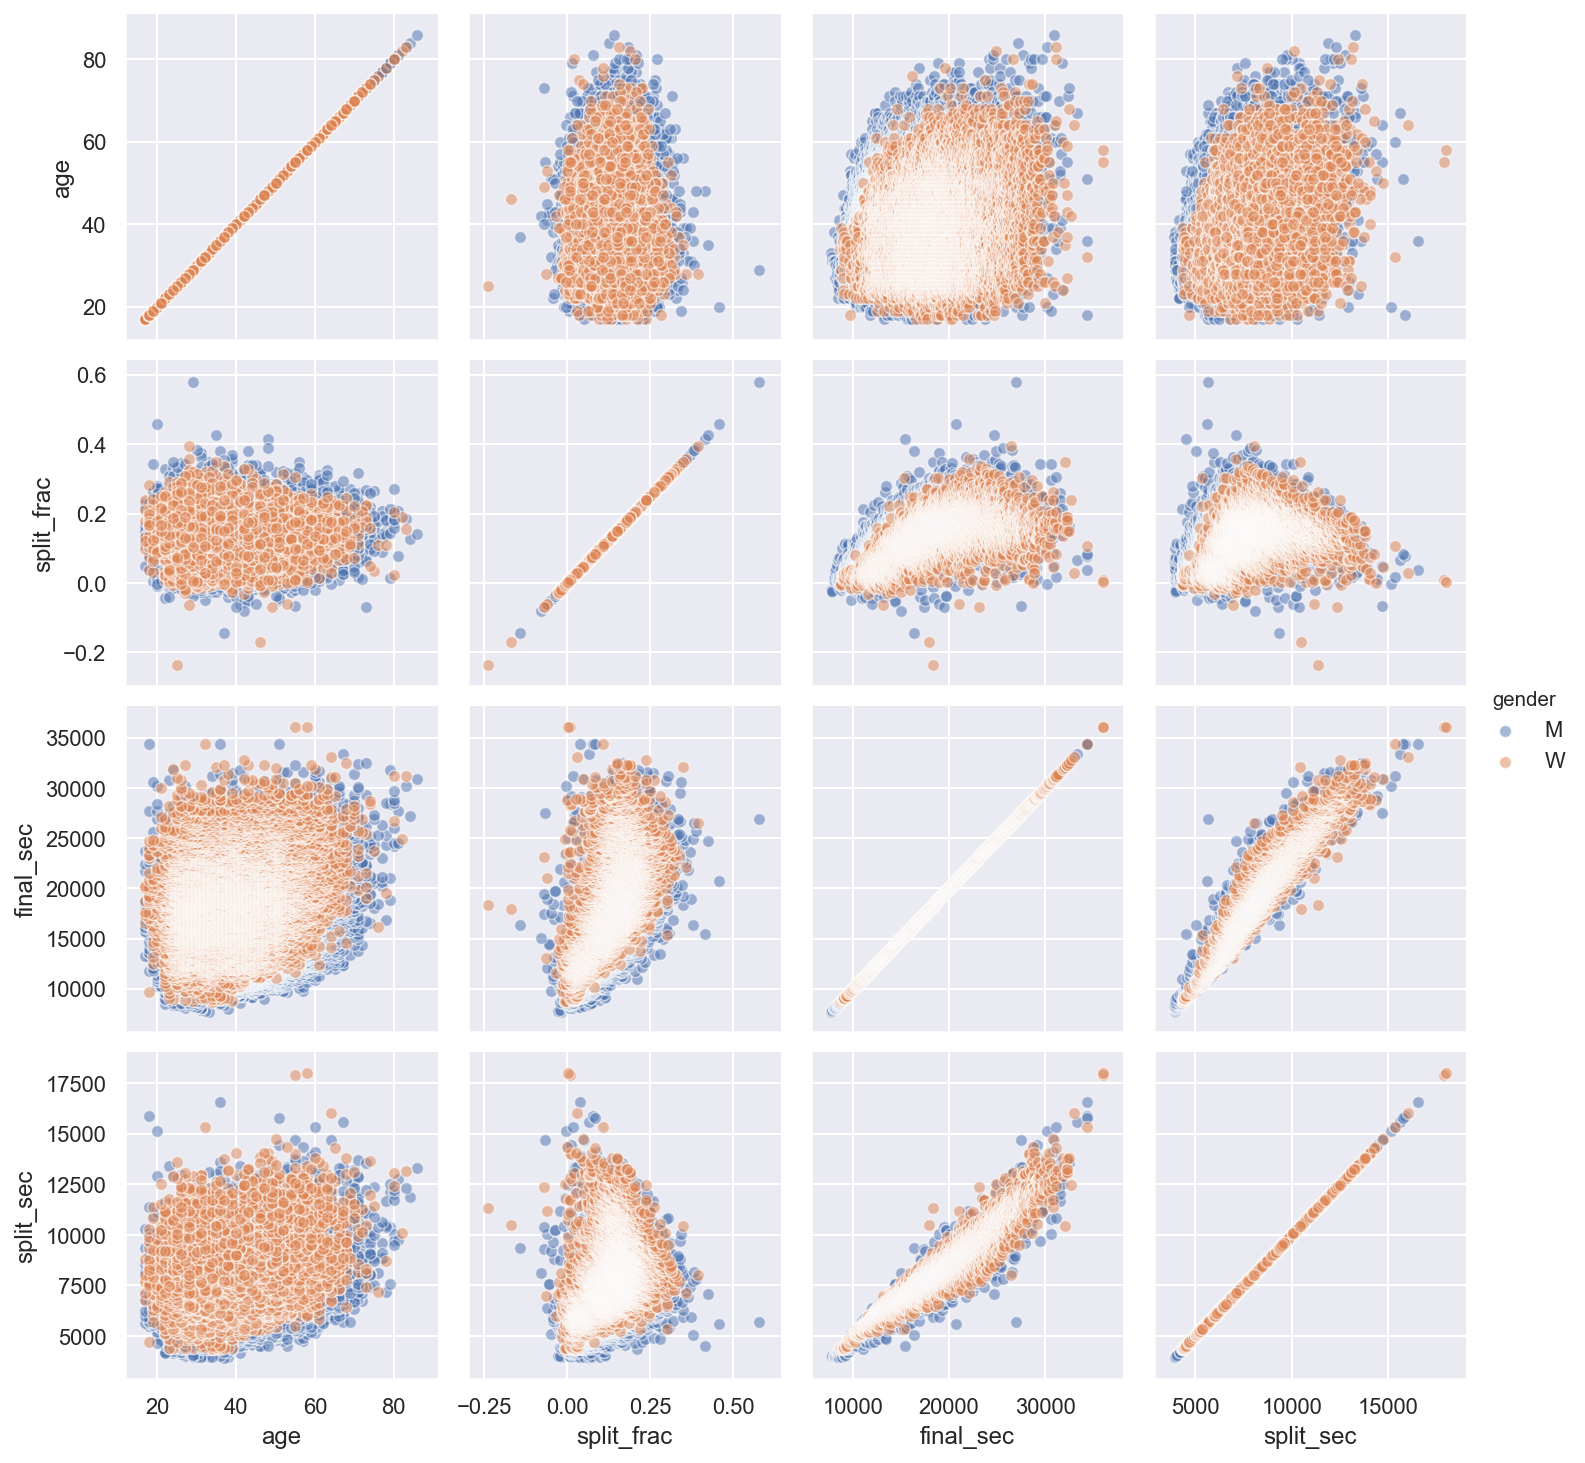

In [161]:
# Pairgrid to inspect correlations among variables

g = sns.PairGrid(df, hue='gender',
                 vars=['age', 'split_frac', 'final_sec', 'split_sec'])
g.map(sns.scatterplot, alpha=0.5)
g.add_legend();

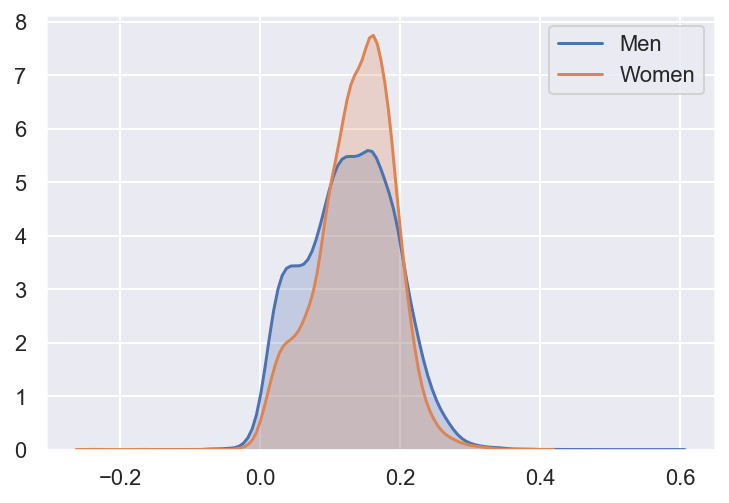

In [165]:
# Split fraction by gender

sns.kdeplot(df.split_frac[df.gender=='M'], label='Men', shade=True)
sns.kdeplot(df.split_frac[df.gender=='W'], label='Women', shade=True);

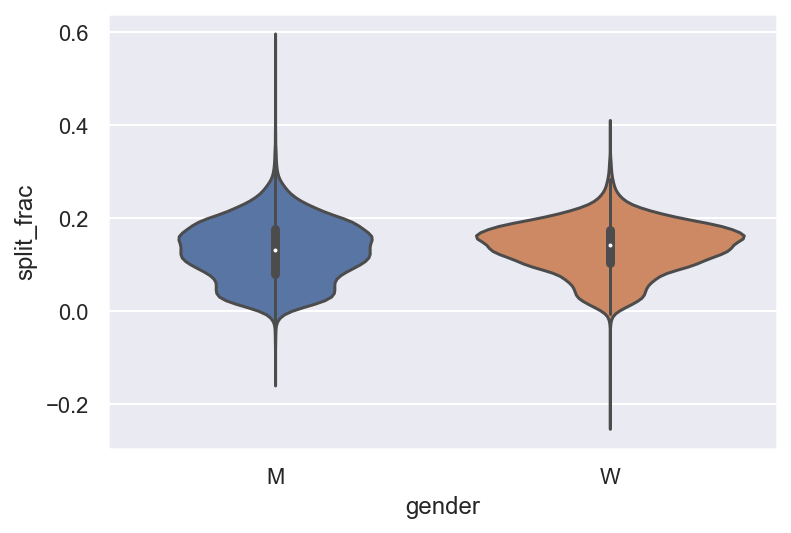

In [169]:
# Split fraction by gender using violin plots

sns.violinplot('gender', 'split_frac', data=df);

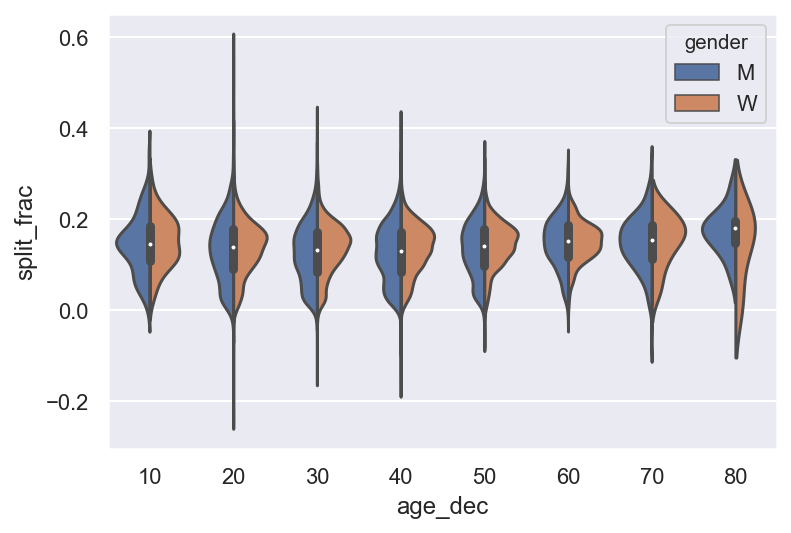

In [179]:
# Split fraction by gender and age using violin plots

df['age_dec'] = df.age.map(lambda age: age // 10 * 10)

sns.violinplot('age_dec', 'split_frac', hue='gender', split=True, data=df);

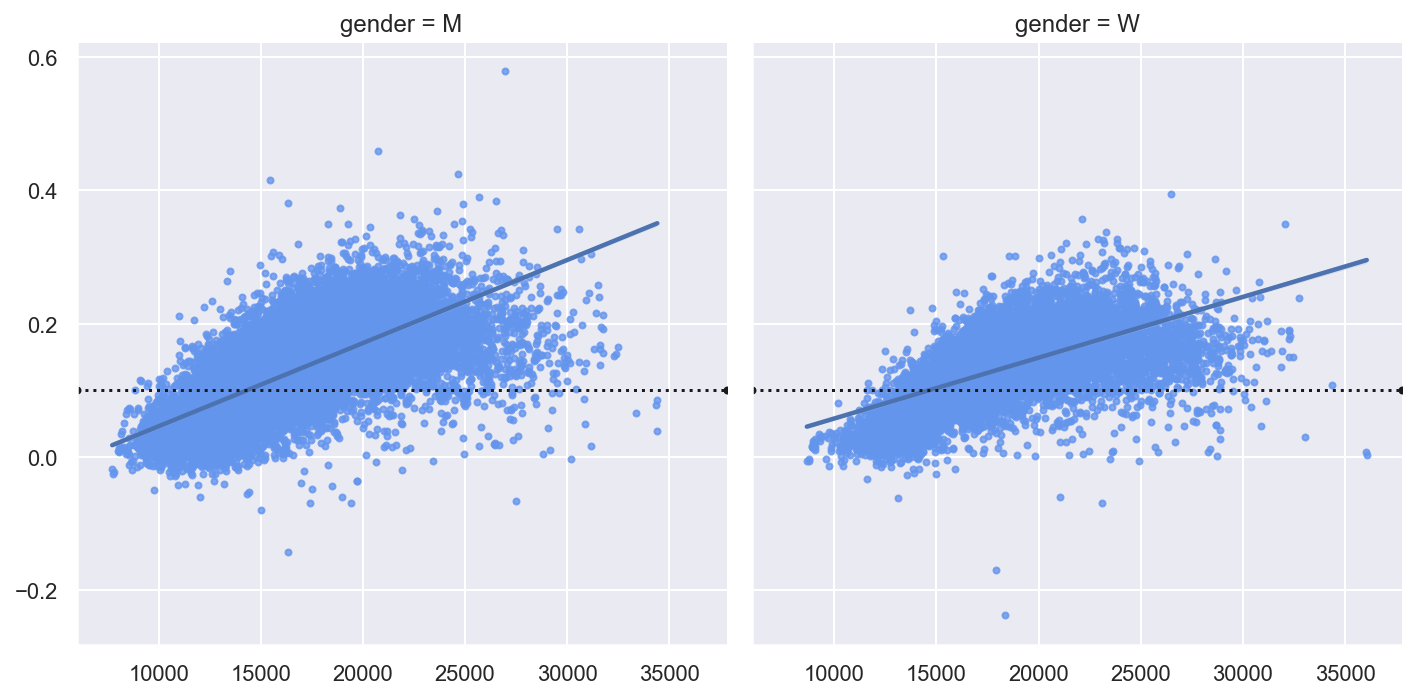

In [187]:
# Identify negative splitters

g = sns.lmplot('final_sec', 'split_frac', col='gender', data=df, markers='.', scatter_kws=dict(color='cornflowerblue'))
g.map(plt.axhline, y=0.1, color='k', ls=':');

## Sources

- [Python for Data Analysis](https://www.oreilly.com/library/view/python-for-data/9781491957653/)
- [Python Data Science Handbook](https://www.oreilly.com/library/view/python-data-science/9781491912126/)

## TED talks

Analysing TED talks following [this] talk.

In [2]:
path = 'https://raw.githubusercontent.com/justmarkham/pycon-2019-tutorial/master/ted.csv'
ted = pd.read_csv(path)
ted.head(2)

comments                                        description  duration  \
0      4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1       265  With the same humor and humanity he exuded in ...       977   

     event   film_date  languages  main_speaker  \
0  TED2006  1140825600         60  Ken Robinson   
1  TED2006  1140825600         43       Al Gore   

                                        name  num_speaker  published_date  \
0  Ken Robinson: Do schools kill creativity?            1      1151367060   
1       Al Gore: Averting the climate crisis            1      1151367060   

                                             ratings  \
0  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   

                                       related_talks speaker_occupation  \
0  [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...    Author/educator   
1  [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   Climate advocate   

                                                tags  \
0  ['children', 'creativity', 'culture', 'dance',...   
1  ['alternative energy', 'cars', 'climate change...   

                         title  \
0  Do schools kill creativity?   
1  Averting the climate crisis   

                                                 url     views  
0  https://www.ted.com/talks/ken_robinson_says_sc...  47227110  
1  https://www.ted.com/talks/al_gore_on_averting_...   3200520

In [3]:
ted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2550 non-null   int64 
 1   description         2550 non-null   object
 2   duration            2550 non-null   int64 
 3   event               2550 non-null   object
 4   film_date           2550 non-null   int64 
 5   languages           2550 non-null   int64 
 6   main_speaker        2550 non-null   object
 7   name                2550 non-null   object
 8   num_speaker         2550 non-null   int64 
 9   published_date      2550 non-null   int64 
 10  ratings             2550 non-null   object
 11  related_talks       2550 non-null   object
 12  speaker_occupation  2544 non-null   object
 13  tags                2550 non-null   object
 14  title               2550 non-null   object
 15  url                 2550 non-null   object
 16  views               2550

In [9]:
ted.isna().sum()

comments              0
description           0
duration              0
event                 0
film_date             0
languages             0
main_speaker          0
name                  0
num_speaker           0
published_date        0
ratings               0
related_talks         0
speaker_occupation    6
tags                  0
title                 0
url                   0
views                 0
dtype: int64

## Which talks provoke the most online discussion?

In [32]:
ted['views_per_comment'] = ted.views / ted.comments
vpc = ted.sort_values('views_per_comment')[['name', 'main_speaker', 'views_per_comment']]
display(vpc.head())
display(vpc.tail())

name           main_speaker  \
744    Diane J. Savino: The case for same-sex marriage        Diane J. Savino   
803              David Bismark: E-voting without fraud          David Bismark   
96                   Richard Dawkins: Militant atheism        Richard Dawkins   
694  Sharmeen Obaid-Chinoy: Inside a school for sui...  Sharmeen Obaid-Chinoy   
954       Janet Echelman: Taking imagination seriously         Janet Echelman   

     views_per_comment  
744         450.531587  
803         651.739808  
96          683.134291  
694         703.886818  
954         735.525682

name        main_speaker  \
2494  Jimmy Lin: A simple new blood test that can ca...           Jimmy Lin   
2528  Chance Coughenour: How your pictures can help ...   Chance Coughenour   
2542  Sethembile Msezane: Living sculptures that sta...  Sethembile Msezane   
2501  Françoise Mouly: The stories behind The New Yo...     Françoise Mouly   
2534  Benjamin Grant: What it feels like to see Eart...      Benjamin Grant   

      views_per_comment  
2494      143643.714286  
2528      179735.666667  
2542      180696.000000  
2501      279680.000000  
2534      323087.000000

# Plot the distribution of comments

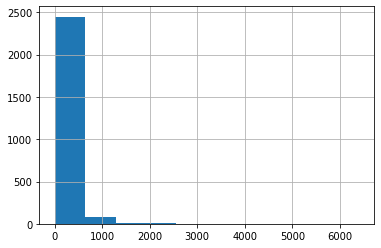

In [132]:
ted.comments.hist();

In [34]:
ted[ted.comments >= 1500].shape

(17, 19)

Most talks have fewer than 1500 comments (only 17 have more), so I drop the ones that have more. I initially tried to avoid this, but as Keving points out in the video: plotting entails decision making, as a plot is a summary of your data and not a representation of all your data. This is a good lesson to take away from this.

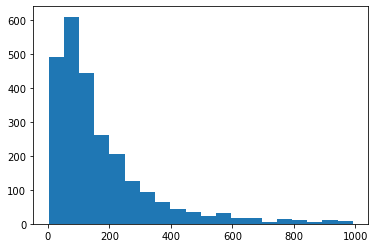

In [35]:
ted.loc[ted.comments < 1000, 'comments'].hist(bins=20, grid=False);

## Plot the number of talks that took place each year

In [45]:
ted.published_date

744     1282062180
803     1288685640
96      1176689220
694     1274865960
954     1307489760
           ...    
2494    1500994384
2528    1504209631
2542    1505488093
2501    1501770244
2534    1504814438
Name: published_date, Length: 2550, dtype: int64

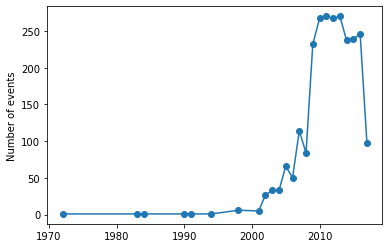

In [79]:
(pd.to_datetime(ted.film_date, unit='s').dt.year
 .value_counts()
 .sort_index()
 .plot(marker='o', ylabel='Number of events'));

# What were the "best" events in TED history to attend

Defining "best" as event with most overall views, this is simple

In [98]:
ted.groupby('event').views.sum().sort_values(ascending=False)[:5]

event
TED2013           177307937
TED2014           174121423
TEDGlobal 2013    170554736
TED2015           150826305
TED2006           147345533
Name: views, dtype: int64

# Unpack the ratings data

In [205]:
ted.ratings[0]

"[{'id': 7, 'name': 'Funny', 'count': 19645}, {'id': 1, 'name': 'Beautiful', 'count': 4573}, {'id': 9, 'name': 'Ingenious', 'count': 6073}, {'id': 3, 'name': 'Courageous', 'count': 3253}, {'id': 11, 'name': 'Longwinded', 'count': 387}, {'id': 2, 'name': 'Confusing', 'count': 242}, {'id': 8, 'name': 'Informative', 'count': 7346}, {'id': 22, 'name': 'Fascinating', 'count': 10581}, {'id': 21, 'name': 'Unconvincing', 'count': 300}, {'id': 24, 'name': 'Persuasive', 'count': 10704}, {'id': 23, 'name': 'Jaw-dropping', 'count': 4439}, {'id': 25, 'name': 'OK', 'count': 1174}, {'id': 26, 'name': 'Obnoxious', 'count': 209}, {'id': 10, 'name': 'Inspiring', 'count': 24924}]"

In [206]:
import ast
ast.literal_eval(ted.ratings[0])

[{'id': 7, 'name': 'Funny', 'count': 19645},
 {'id': 1, 'name': 'Beautiful', 'count': 4573},
 {'id': 9, 'name': 'Ingenious', 'count': 6073},
 {'id': 3, 'name': 'Courageous', 'count': 3253},
 {'id': 11, 'name': 'Longwinded', 'count': 387},
 {'id': 2, 'name': 'Confusing', 'count': 242},
 {'id': 8, 'name': 'Informative', 'count': 7346},
 {'id': 22, 'name': 'Fascinating', 'count': 10581},
 {'id': 21, 'name': 'Unconvincing', 'count': 300},
 {'id': 24, 'name': 'Persuasive', 'count': 10704},
 {'id': 23, 'name': 'Jaw-dropping', 'count': 4439},
 {'id': 25, 'name': 'OK', 'count': 1174},
 {'id': 26, 'name': 'Obnoxious', 'count': 209},
 {'id': 10, 'name': 'Inspiring', 'count': 24924}]

In [207]:
ted['ratings'] = ted.ratings.apply(ast.literal_eval)

pieces = []
for idx, talk in ted.iterrows():
    df = pd.DataFrame(talk['ratings'])
    df['talk_name'] = talk['name']
    pieces.append(df)
    
ratings = pd.concat(pieces)
ratings.head()

id        name  count                                  talk_name
0   7       Funny  19645  Ken Robinson: Do schools kill creativity?
1   1   Beautiful   4573  Ken Robinson: Do schools kill creativity?
2   9   Ingenious   6073  Ken Robinson: Do schools kill creativity?
3   3  Courageous   3253  Ken Robinson: Do schools kill creativity?
4  11  Longwinded    387  Ken Robinson: Do schools kill creativity?

# Count total number of ratings received by each talk

In [208]:
def counter(list_of_dics):
    return sum(a['count'] for a in list_of_dics)

ted.ratings.apply(counter)

0       93850
1        2936
2        2824
3        3728
4       25620
        ...  
2545      192
2546      151
2547      136
2548      583
2549      142
Name: ratings, Length: 2550, dtype: int64

## Cran packages

Analyse R packages on CRAN as part of the Tidy Tuesday [challenge](https://github.com/rfordatascience/tidytuesday/tree/master/data/2019/2019-11-12), then compare with [David Robinson's approach](https://www.youtube.com/watch?v=dr4qw8o0nYU).

In [3]:
fp = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-11-12/loc_cran_packages.csv'
cran = pd.read_csv(fp)
cran.head(2)

file language  blank  comment  code pkg_name version
0     2        R     96      353   365       A3   1.0.0
1     1     HTML    347        5  2661    aaSEA   1.0.0

<AxesSubplot:ylabel='pkg_name'>

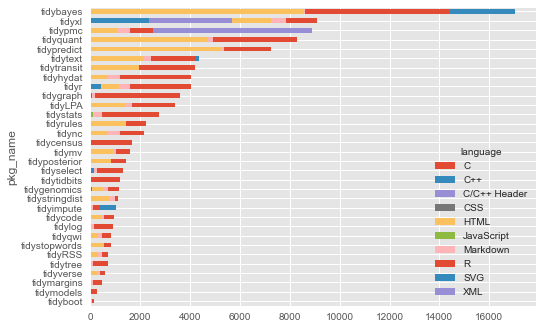

In [14]:
# Lines of code from different languages for tidyverse packages

plt.style.use('ggplot')
(cran[cran.pkg_name.str.contains("^tidy")]
 .groupby(["pkg_name", "language"]).code.sum()
 .unstack()
 .assign(tot=lambda x: x.sum(axis=1))
 .sort_values('tot')
 .drop('tot', axis=1)
).plot.barh(stacked=True)